In [ ]:
import os
import glob

from tqdm import trange
import random
import math

from dateutil import parser
from datetime import datetime
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#directory: 


In [ ]:
current_working_directory = os.getcwd()
print(current_working_directory)
from datetime import datetime

# Get the current date
current_date = datetime.now().date()
model_add_path = f'playround_models/lstm/{current_date}'

if not os.path.exists(current_working_directory + '/' + model_add_path):
    os.makedirs(current_working_directory + '/' + model_add_path)

In [ ]:
config = {
  "plots": {
        "show_plots": False,
        "xticks_interval": 1200,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#FF4136",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "data": {
        "window_size": 100,
        "train_split_size": 0.80,
    }, 
    "model_MO": {
        "input_size": 1, # since we are only using 1 feature, price
        "num_lstm_layers": 5,
        "lstm_size": 16,
        "dropout": 0.25,
        "output_size": 1,
    },
    "training_MO": {
        "batch_size": 1024,
        "num_epoch": 50,
        "learning_rate": 0.005,
        "scheduler_step_size": 10,
    },
    "model_MM": {
        "input_size": 1, # since we are only using 1 feature, price
        "num_lstm_layers": 5,
        "lstm_size": 16,
        "dropout": 0.4,
        "target_len": 60,
        "stride": 1,
        "patience": 5, # number of epochs to wait for Early Stopping
    },
    "training_MM": {
        "batch_size": 256,
        "num_epoch": 15,
        "learning_rate": 0.004,
        "scheduler_step_size": 10,
    },
    "paths": {
        "drive": {
            "agg_trade": {
                "train": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/",
                "test": "/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/", 
            },
            "orderbook": {
                "train": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/input_data/orderbook_clean.csv",
                "test": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/input_data/orderbook_test_clean.csv",
            },
            "models": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/models/",
            "figures": "/content/drive/MyDrive/IP/Repos/LSTM_Transformer/figures/",
        },
        "local": {
            "agg_trade": {
                "train": "./data/input_data/",
                "test": "./data/input_data/", 
            },
            "orderbook": {
                "train": "./data/input_data/orderbook_clean.csv",
                "test": "./data/input_data/orderbook_test_clean.csv",
            },
            "models": "./models/",
            "figures": "./figures",
        }
    }
}

## Data preparation

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
drive = False
device

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
date_train = '4000longshot' 
#date_test = 'All_to_Sept'
drive = None
if drive:
    agg_trade = pd.read_csv(config["paths"]["drive"]["agg_trade"]["train"]+date_train+'/orderbook.csv')    
else:
    agg_trade = pd.read_csv(config["paths"]["local"]["agg_trade"]["train"]+date_train+'/orderbook_agg_trade_dollarvol_150000.csv')
    # agg_trade_test = pd.read_csv(config["paths"]["local"]["agg_trade"]["test"]+date_test+'/orderbook_agg_trade_dollarvol.csv')

#agg_trade['price'] = agg_trade['w_midprice']

## Preparing Data for LSTM MO

In [ ]:
def prepare_data_x(data, window_size, lag):
    '''
    Windows the input data for the ML models.
    '''
    n_row = data.shape[0] - window_size + 1
    subset = data[:window_size]
    subset_mean = np.mean(subset, axis=0)
    output = np.zeros([n_row, window_size, len(subset_mean)])
    x_mean = np.zeros([n_row, len(subset_mean)])
    x_std = np.zeros([n_row, len(subset_mean)])
    for idx in range(n_row):
        subset = data[idx:idx+window_size]
        subset_mean = np.mean(subset, axis=0)
        subset_std = np.std(subset, axis=0) + 0.01
        subset_norm = (subset-subset_mean)/subset_std
        x_mean[idx,:] = subset_mean
        x_std[idx,:] = subset_std
        output[idx,:,:] = subset_norm
    x_mean = np.array(x_mean)
    x_std = np.array(x_std)
    return output[:-lag-1], output[-1], x_mean, x_std

def prepare_data_y(x, window_size, lag):
    '''
    Windows the target data for the ML models.
    '''
    output = np.zeros([len(x)-window_size-lag])
    std = 1.1*np.sqrt(lag)+lag*0.01
    for idx in range(0,len(x)-window_size-lag):
        output[idx] = np.log(x[window_size+lag-1+idx,0]/x[window_size-1+idx,0])*10_000
    output = output/std
    return output

def prepare_data(normalized_prices_train, dates_train, normalized_prices_test, dates_test, config, lag=1, plot=False):
    '''
    Returns input and target data.
    '''
    data_x, data_x_unseen, x_mean, x_std = prepare_data_x(normalized_prices_train, window_size=config["data"]["window_size"], lag=lag)
    data_y = prepare_data_y(normalized_prices_train, window_size=config["data"]["window_size"], lag=lag)

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val

## Preparing Data for LSTM MM

In [ ]:
# The following helper functions and models were based on existing code: https://github.com/lkulowski/LSTM_encoder_decoder

def train_test_split(datetime, price, split = 0.8):
  '''
  Splits time series into train/test sets.
  '''  
  datetime = np.array(datetime)
  price = np.array(price)
  
  indx_split = int(split * len(price))
  indx_train = np.arange(0, indx_split, dtype=int)
  indx_val = np.arange(indx_split, len(price), dtype=int)
    
  t_train = datetime[indx_train]
  y_train = price[indx_train]
  y_train = y_train.reshape(-1, 1)
  
  t_val = datetime[indx_val]
  y_val = price[indx_val]
  y_val = y_val.reshape(-1, 1)
  
  return t_train, y_train, t_val, y_val 


def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
    '''
    Creates a windowed dataset.
    '''
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1

    X = np.zeros([input_window, num_samples, num_features])
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y


def numpy_to_torch(x_train, y_train, x_validation, y_validation, device):
    '''
    Converts numpy array to PyTorch tensor.
    '''
    x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).to(device)

    x_test_torch = torch.from_numpy(x_validation).type(torch.Tensor).to(device)
    y_test_torch = torch.from_numpy(y_validation).type(torch.Tensor).to(device)
    
    return x_train_torch, y_train_torch, x_test_torch, y_test_torch

## Defining the Many-to-One LSTM model

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [ ]:
class LSTM_MO(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.prelu = nn.PReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()


    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)


    def forward(self, x):
        batchsize = x.shape[0]
        x = self.linear_1(x)
        x = self.prelu(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


    def train_model(self, train_dataloader, val_dataloader, learning_rate, scheduler_step_size, n_epochs=50, device="cpu", save_path=None, forecast_window=None):
      
        def run_epoch(dataloader, is_training=False):
            epoch_loss = 0
            outputs = torch.Tensor(0).to(device)
            targets = torch.Tensor(0).to(device)
            if is_training:
                self.train()
            else:
                self.eval()
            for idx, (x, y) in enumerate(dataloader):
                if is_training:
                    optimizer.zero_grad()

                batchsize = x.shape[0]
                x = x.to(device)
                y = y.to(device)
                out = self.forward(x)
                loss = criterion(out.contiguous(), y.contiguous())

                if is_training:
                    loss.backward()
                    optimizer.step()
                
                if not is_training:
                    outputs = torch.cat((outputs.contiguous(), out))
                    targets = torch.cat((targets, y.contiguous()))
                    
                epoch_loss += (loss.detach().item() / batchsize)
                
            lr = scheduler.get_last_lr()[0]
            if not is_training:
                print(outputs.cpu().detach().numpy())
                print(targets.cpu().detach().numpy())
                plt.plot(targets.cpu().detach().numpy(), alpha=0.3)
                plt.plot(outputs.cpu().detach().numpy())
                plt.show()
                r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                return epoch_loss, lr, r2
            else:
                return epoch_loss, lr

      
        # define optimizer, scheduler and loss function
        criterion = nn.MSELoss(reduction='sum')
        optimizer = optim.AdamW(model_MO.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.995)

        # begin training
        for epoch in range(n_epochs):
            loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
            loss_val, lr_val, r2 = run_epoch(val_dataloader)
            scheduler.step()

            if save_path:
                results = {
                        'model': 'LSTM_MO',
                        'pred_len': forecast_window,
                        'epoch': epoch,
                        'train_loss': loss_train,
                        'val_loss': loss_val,
                        'r2_val_sklearn': r2            
                }

                df = pd.DataFrame([results])
                df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)

            
            print('Epoch[{}/{}] | loss train:{:.6f}, val loss:{:.6f} | lr:{:.6f} | r2: {:.5f}|'
                      .format(epoch+1, n_epochs, loss_train, loss_val, lr_train, r2))

## Defining the Many-to-Many LSTM Model

## Model training - Many to One

In [ ]:
def augment_trade_data(df, lag=0, forecast_window=None):
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]

Epoch[1/5] | loss train:205.546244, val loss:51.384745 | lr:0.001000 | r2: 0.23839|


[-0.29738882  0.44379094 -0.16708821 ...  0.32665986  0.2020503
 -0.12767704]
[ 0.64256537  0.73882264 -1.014567   ...  1.1903912  -0.03431259
 -1.6581441 ]


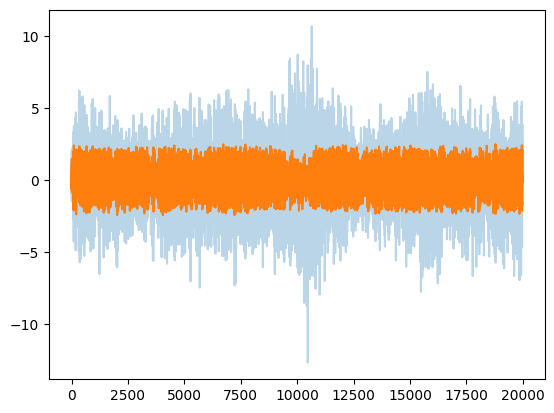

Epoch[2/5] | loss train:191.093093, val loss:50.661520 | lr:0.001000 | r2: 0.24906|
[-0.3544082   0.5706234  -0.13424115 ...  0.37631124  0.21836877
 -0.17114885]
[ 0.64256537  0.73882264 -1.014567   ...  1.1903912  -0.03431259
 -1.6581441 ]


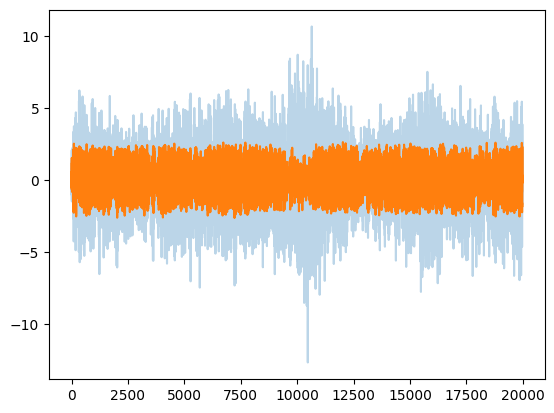

Epoch[3/5] | loss train:188.662473, val loss:50.297805 | lr:0.001000 | r2: 0.25445|
[-0.4277263   0.6472597  -0.17147242 ...  0.45548746  0.2677813
 -0.15528117]
[ 0.64256537  0.73882264 -1.014567   ...  1.1903912  -0.03431259
 -1.6581441 ]


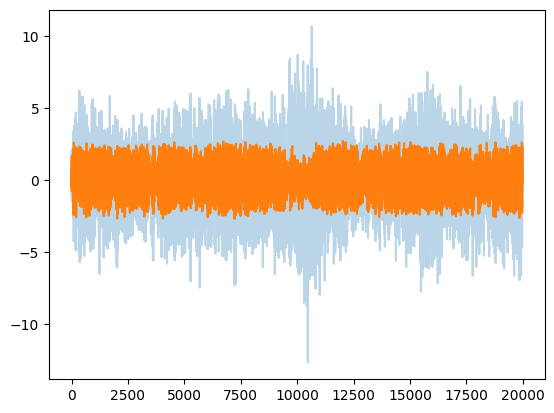

Epoch[4/5] | loss train:187.202065, val loss:50.072826 | lr:0.001000 | r2: 0.25777|
[-0.48275498  0.69642466 -0.19212414 ...  0.54044884  0.31966522
 -0.18926826]
[ 0.64256537  0.73882264 -1.014567   ...  1.1903912  -0.03431259
 -1.6581441 ]


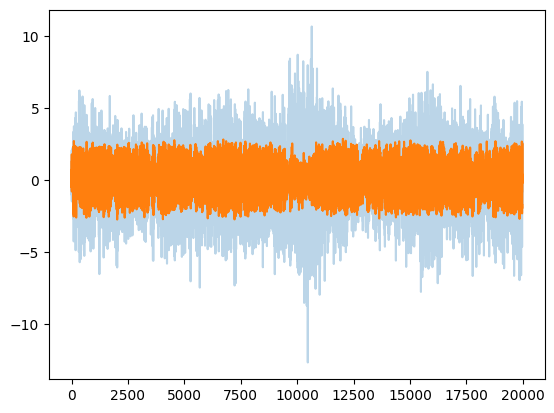

Epoch[5/5] | loss train:186.211378, val loss:49.933442 | lr:0.001000 | r2: 0.25983|
Done with prediction len 1.
Train data shape (79918, 100, 38) (79918,)
Validation data shape (19980, 100, 38) (19980,)
[-0.09182301  0.20121941 -0.15313023 ...  0.1255645   0.1496622
 -0.153838  ]
[ 0.97315735 -0.19425577 -1.2079685  ...  0.81443185 -1.1922983
 -1.4067228 ]


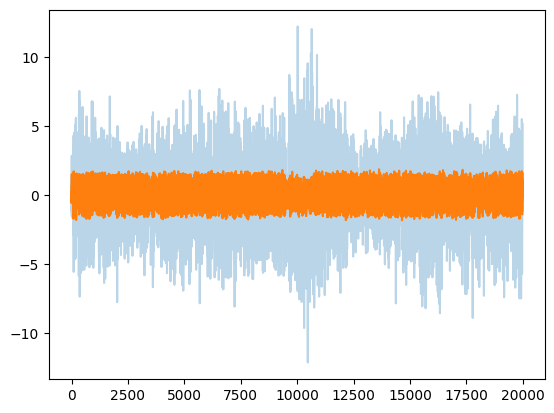

Epoch[1/5] | loss train:307.097603, val loss:80.686104 | lr:0.001000 | r2: 0.10657|
[-0.10961823  0.28574294 -0.12998368 ...  0.27706778  0.19646849
 -0.1398489 ]
[ 0.97315735 -0.19425577 -1.2079685  ...  0.81443185 -1.1922983
 -1.4067228 ]


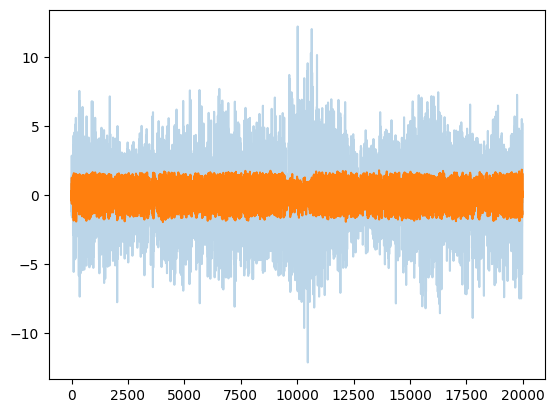

Epoch[2/5] | loss train:296.980078, val loss:80.366762 | lr:0.001000 | r2: 0.11001|
[-0.1411447   0.3131973  -0.11985277 ...  0.32652906  0.20017841
 -0.15681383]
[ 0.97315735 -0.19425577 -1.2079685  ...  0.81443185 -1.1922983
 -1.4067228 ]


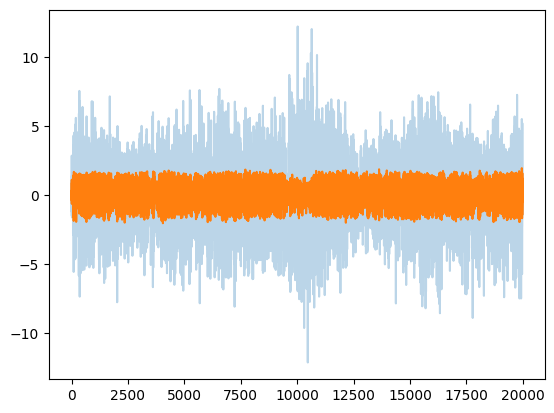

Epoch[3/5] | loss train:295.393494, val loss:80.176720 | lr:0.001000 | r2: 0.11214|
[-0.17978248  0.35653925 -0.09971491 ...  0.39783487  0.23691541
 -0.17691231]
[ 0.97315735 -0.19425577 -1.2079685  ...  0.81443185 -1.1922983
 -1.4067228 ]


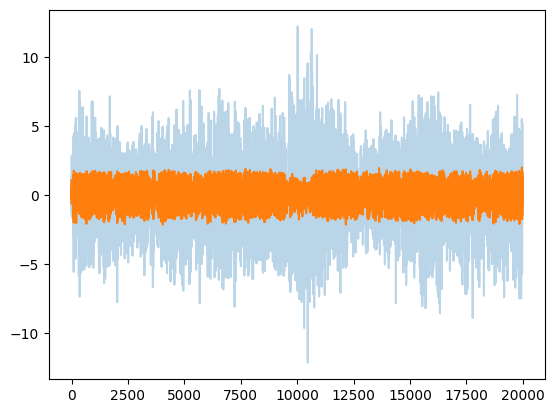

Epoch[4/5] | loss train:294.419322, val loss:80.071080 | lr:0.001000 | r2: 0.11334|
[-0.21287006  0.34534615 -0.06515339 ...  0.40990895  0.23776528
 -0.2190432 ]
[ 0.97315735 -0.19425577 -1.2079685  ...  0.81443185 -1.1922983
 -1.4067228 ]


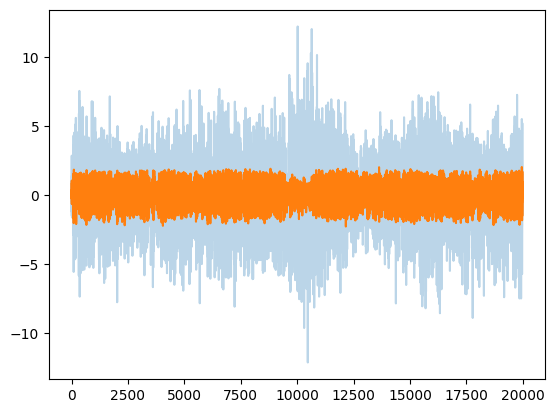

Epoch[5/5] | loss train:293.551816, val loss:79.937912 | lr:0.001000 | r2: 0.11478|
Done with prediction len 2.
Train data shape (79917, 100, 38) (79917,)
Validation data shape (19980, 100, 38) (19980,)
[-0.1044701   0.15223366 -0.06345826 ...  0.07696176  0.0507127
 -0.08250624]
[ 0.21039665 -0.5597317  -1.3485767  ... -0.28796846 -1.1649976
 -0.23300233]


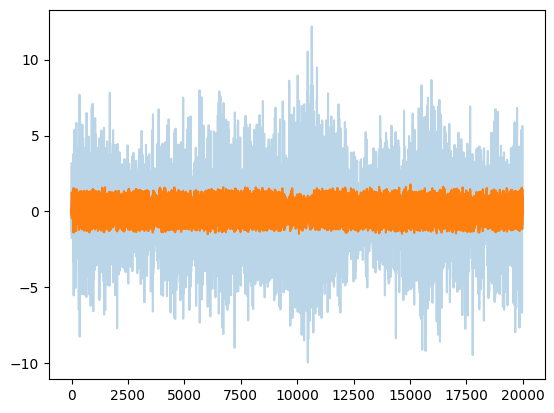

Epoch[1/5] | loss train:348.264990, val loss:92.623943 | lr:0.001000 | r2: 0.06235|
[-0.1971411   0.15124062 -0.1189315  ...  0.13568516  0.13763334
 -0.0504752 ]
[ 0.21039665 -0.5597317  -1.3485767  ... -0.28796846 -1.1649976
 -0.23300233]


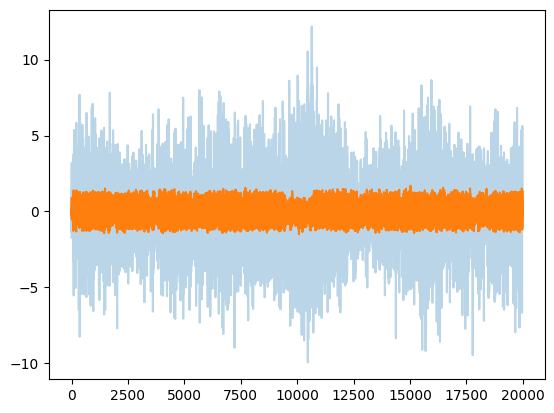

Epoch[2/5] | loss train:341.251019, val loss:92.322703 | lr:0.001000 | r2: 0.06541|
[-0.20441386  0.17286226 -0.09871008 ...  0.19025752  0.15737107
 -0.06364248]
[ 0.21039665 -0.5597317  -1.3485767  ... -0.28796846 -1.1649976
 -0.23300233]


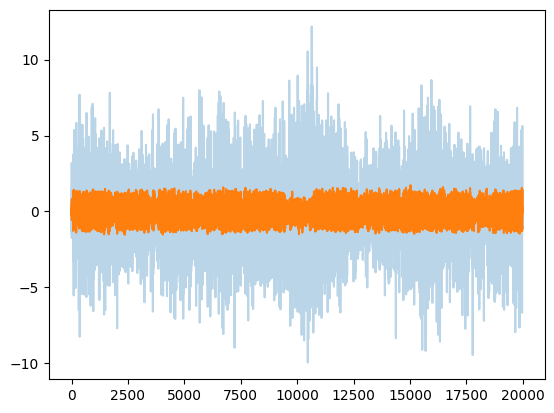

Epoch[3/5] | loss train:340.088138, val loss:92.165624 | lr:0.001000 | r2: 0.06697|
[-0.203129    0.1717899  -0.08975206 ...  0.21099363  0.18032628
 -0.08933535]
[ 0.21039665 -0.5597317  -1.3485767  ... -0.28796846 -1.1649976
 -0.23300233]


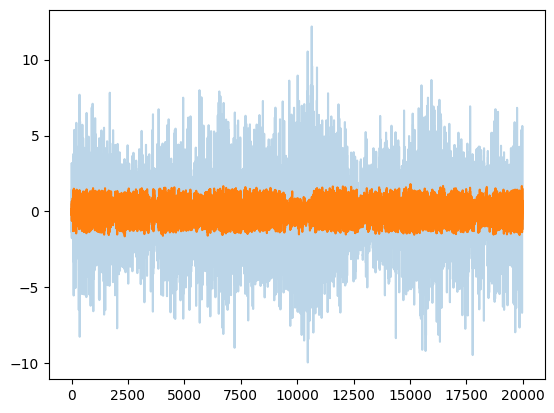

Epoch[4/5] | loss train:339.211177, val loss:92.103324 | lr:0.001000 | r2: 0.06760|
[-0.2182938   0.22279897 -0.07467656 ...  0.23760618  0.16621552
 -0.15478377]
[ 0.21039665 -0.5597317  -1.3485767  ... -0.28796846 -1.1649976
 -0.23300233]


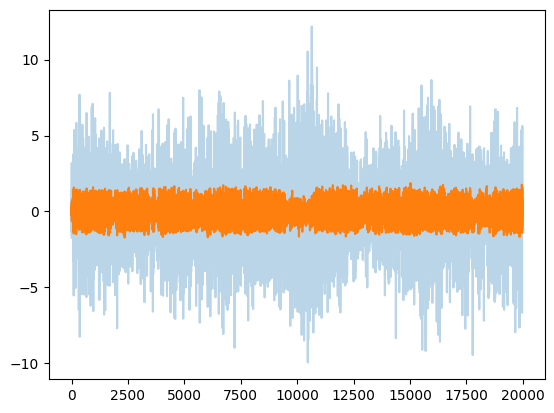

Epoch[5/5] | loss train:338.478110, val loss:92.026936 | lr:0.001000 | r2: 0.06833|
Done with prediction len 3.
Train data shape (79916, 100, 38) (79916,)
Validation data shape (19980, 100, 38) (19980,)
[-0.20524085  0.05001598 -0.11752097 ...  0.23792441  0.15624687
  0.06065849]
[-0.16516814 -0.79899454 -1.1679014  ... -0.4166224  -0.2183063
  0.31358445]


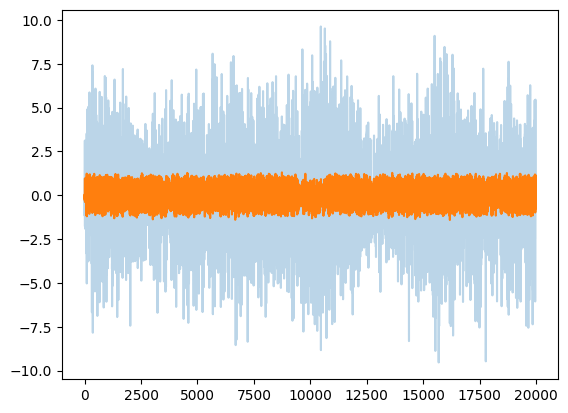

Epoch[1/5] | loss train:370.846321, val loss:98.207333 | lr:0.001000 | r2: 0.03951|
[-0.251581    0.0615297  -0.20066515 ...  0.18699172  0.16726664
  0.06230906]
[-0.16516814 -0.79899454 -1.1679014  ... -0.4166224  -0.2183063
  0.31358445]


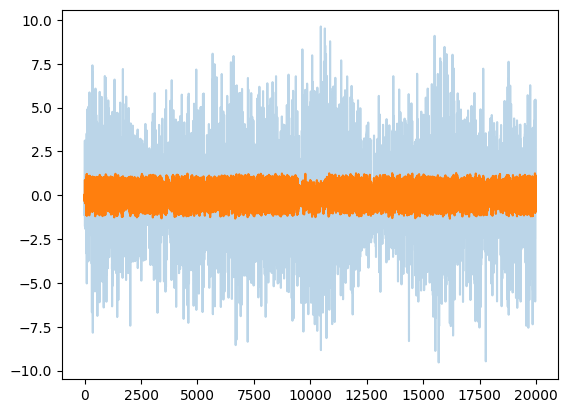

Epoch[2/5] | loss train:364.857623, val loss:97.806379 | lr:0.001000 | r2: 0.04356|
[-0.25575873  0.09480706 -0.19763437 ...  0.24929327  0.19130747
  0.07974893]
[-0.16516814 -0.79899454 -1.1679014  ... -0.4166224  -0.2183063
  0.31358445]


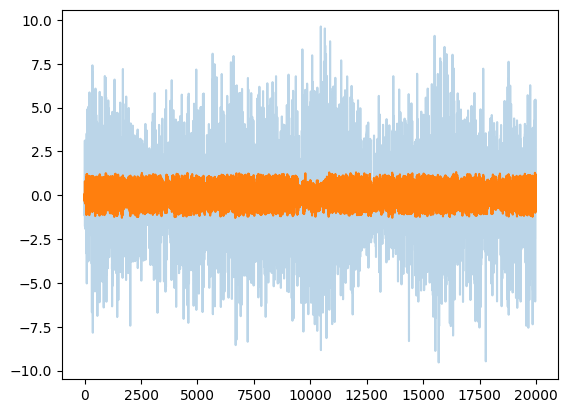

Epoch[3/5] | loss train:363.834340, val loss:97.646751 | lr:0.001000 | r2: 0.04513|
[-0.24725251  0.12129498 -0.1687254  ...  0.31265464  0.21183972
  0.06605187]
[-0.16516814 -0.79899454 -1.1679014  ... -0.4166224  -0.2183063
  0.31358445]


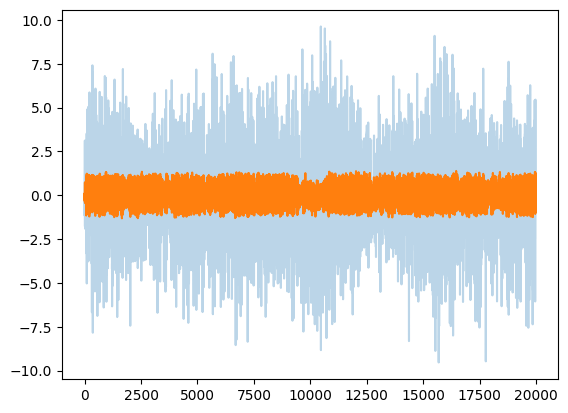

Epoch[4/5] | loss train:363.228424, val loss:97.575315 | lr:0.001000 | r2: 0.04580|
[-0.17324853  0.17305627 -0.09686801 ...  0.3410072   0.23027551
  0.0457004 ]
[-0.16516814 -0.79899454 -1.1679014  ... -0.4166224  -0.2183063
  0.31358445]


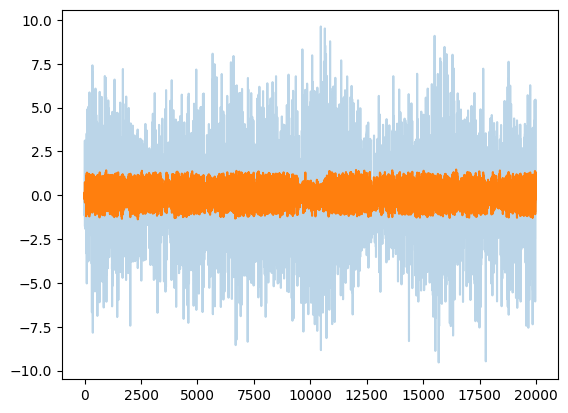

Epoch[5/5] | loss train:362.826283, val loss:97.479231 | lr:0.001000 | r2: 0.04666|
Done with prediction len 4.
Train data shape (79916, 100, 38) (79916,)
Validation data shape (19979, 100, 38) (19979,)
[ 0.05157364 -0.09425767 -0.11866795 ...  0.28914696  0.14280447
  0.06183505]
[-0.715633   -1.0880799  -1.0924181  ...  0.33164778  0.26471245
  0.03381122]


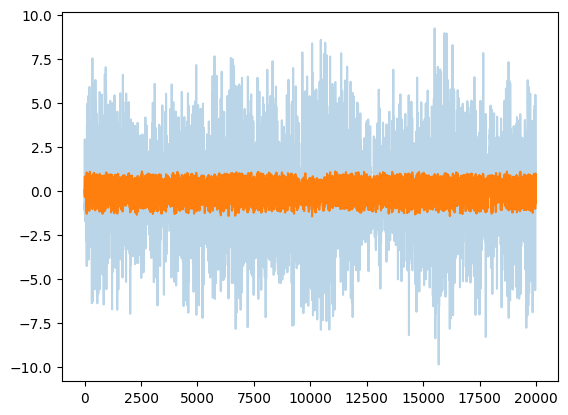

Epoch[1/5] | loss train:384.531007, val loss:100.876786 | lr:0.001000 | r2: 0.02576|
[ 0.11391324 -0.13087556 -0.111908   ...  0.16272584  0.14826602
  0.05811708]
[-0.715633   -1.0880799  -1.0924181  ...  0.33164778  0.26471245
  0.03381122]


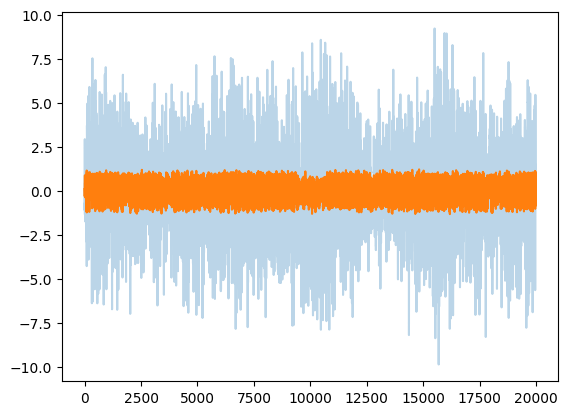

Epoch[2/5] | loss train:379.041387, val loss:100.418438 | lr:0.001000 | r2: 0.03037|
[ 0.15534565 -0.09874436 -0.07090972 ...  0.19976571  0.16815664
  0.05886521]
[-0.715633   -1.0880799  -1.0924181  ...  0.33164778  0.26471245
  0.03381122]


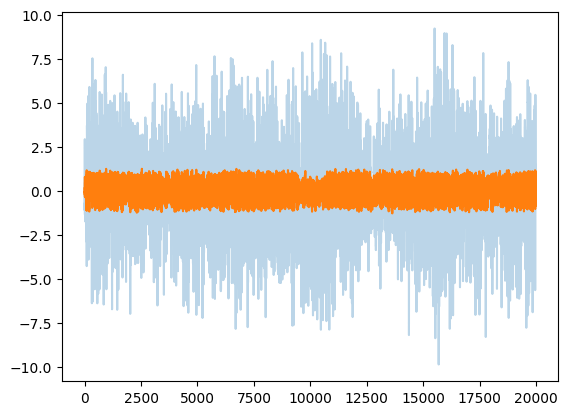

Epoch[3/5] | loss train:378.133386, val loss:100.301086 | lr:0.001000 | r2: 0.03153|
[ 0.22007737 -0.05280627 -0.02651516 ...  0.24748537  0.1904525
  0.04689941]
[-0.715633   -1.0880799  -1.0924181  ...  0.33164778  0.26471245
  0.03381122]


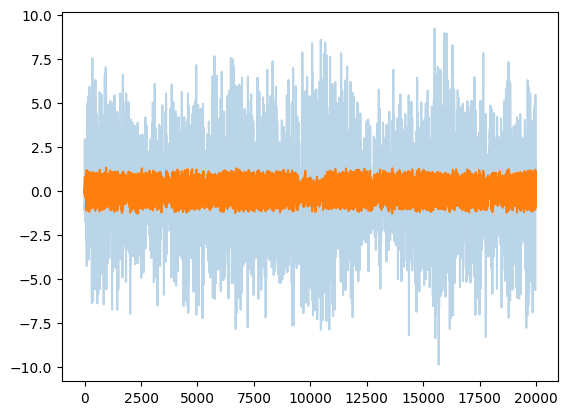

Epoch[4/5] | loss train:377.543240, val loss:100.246237 | lr:0.001000 | r2: 0.03205|
[ 0.25892177 -0.01142958 -0.00187778 ...  0.31006917  0.21187231
  0.02606991]
[-0.715633   -1.0880799  -1.0924181  ...  0.33164778  0.26471245
  0.03381122]


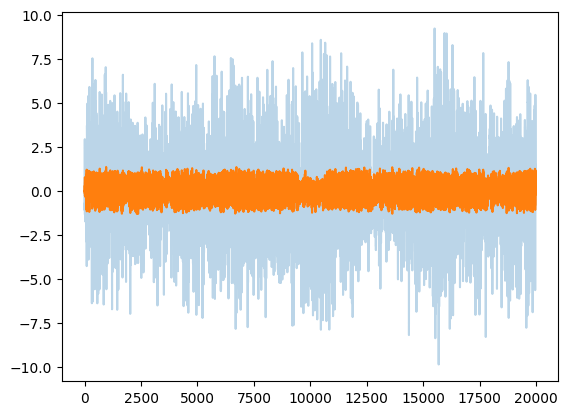

Epoch[5/5] | loss train:376.964418, val loss:100.226323 | lr:0.001000 | r2: 0.03222|
Done with prediction len 5.
Train data shape (79915, 100, 38) (79915,)
Validation data shape (19979, 100, 38) (19979,)
[-0.02150776 -0.10079266 -0.11540182 ...  0.2947276   0.11734319
  0.06479326]
[-0.69365627 -1.4042002  -0.8494714  ...  0.72090054  0.01697921
 -0.6674604 ]


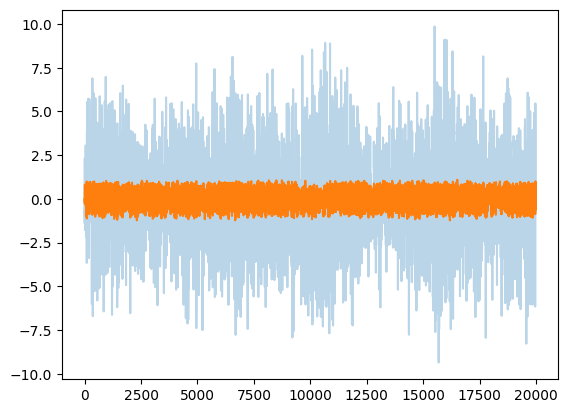

Epoch[1/5] | loss train:392.913893, val loss:101.742566 | lr:0.001000 | r2: 0.01970|
[ 0.02390935 -0.14027955 -0.13514371 ...  0.21247853  0.12817043
  0.10156426]
[-0.69365627 -1.4042002  -0.8494714  ...  0.72090054  0.01697921
 -0.6674604 ]


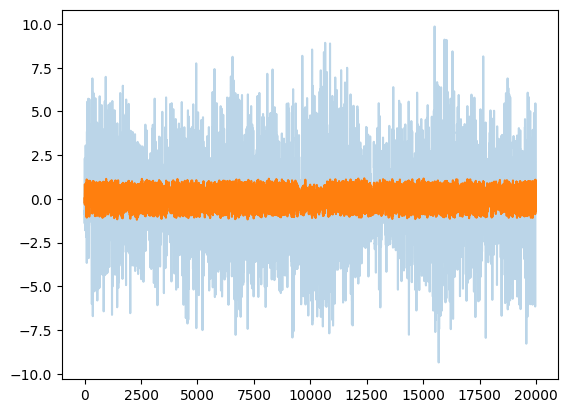

Epoch[2/5] | loss train:388.567998, val loss:101.374474 | lr:0.001000 | r2: 0.02336|
[ 0.05865815 -0.1605038  -0.12872091 ...  0.26875722  0.17617844
  0.12124696]
[-0.69365627 -1.4042002  -0.8494714  ...  0.72090054  0.01697921
 -0.6674604 ]


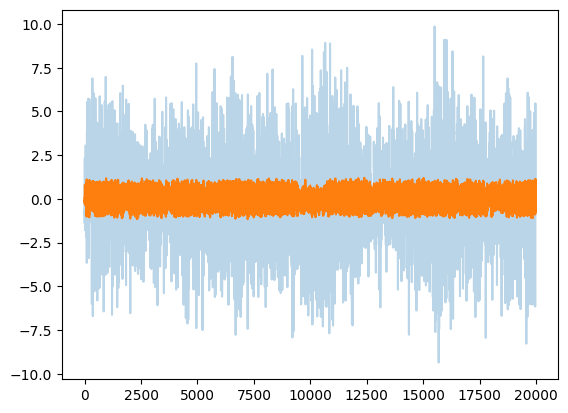

Epoch[3/5] | loss train:387.801694, val loss:101.244505 | lr:0.001000 | r2: 0.02465|
[ 0.12088739 -0.15197258 -0.1014246  ...  0.3079694   0.191063
  0.10246278]
[-0.69365627 -1.4042002  -0.8494714  ...  0.72090054  0.01697921
 -0.6674604 ]


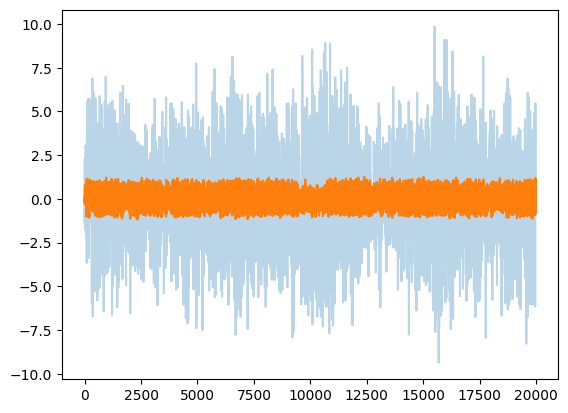

Epoch[4/5] | loss train:387.054816, val loss:101.144532 | lr:0.001000 | r2: 0.02562|
[ 0.19554886 -0.12219055 -0.05113337 ...  0.39543307  0.2501533
  0.1359608 ]
[-0.69365627 -1.4042002  -0.8494714  ...  0.72090054  0.01697921
 -0.6674604 ]


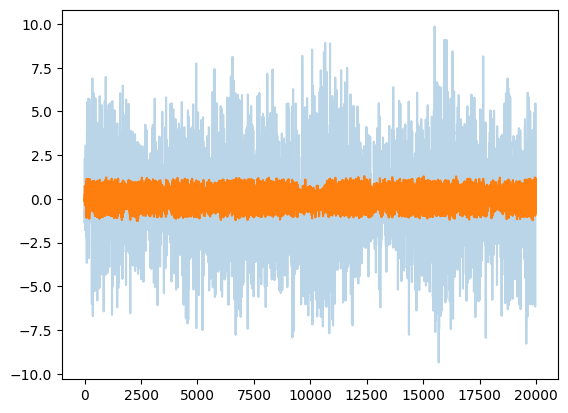

Epoch[5/5] | loss train:386.469500, val loss:101.103657 | lr:0.001000 | r2: 0.02596|
Done with prediction len 6.
Train data shape (79914, 100, 38) (79914,)
Validation data shape (19979, 100, 38) (19979,)
[-0.05552172 -0.12404174 -0.1433982  ...  0.22626607  0.10355487
  0.0306148 ]
[-1.0226028  -1.1629553  -0.21784385 ...  0.4590445  -0.62965107
 -1.5678278 ]


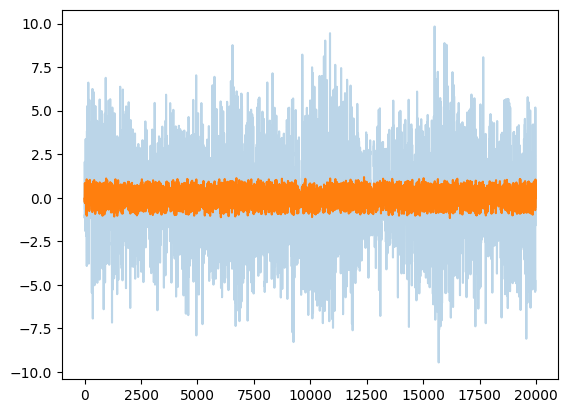

Epoch[1/5] | loss train:399.126759, val loss:101.992242 | lr:0.001000 | r2: 0.01549|
[ 0.0340295  -0.07589048 -0.08235873 ...  0.14081903  0.08644517
  0.01582689]
[-1.0226028  -1.1629553  -0.21784385 ...  0.4590445  -0.62965107
 -1.5678278 ]


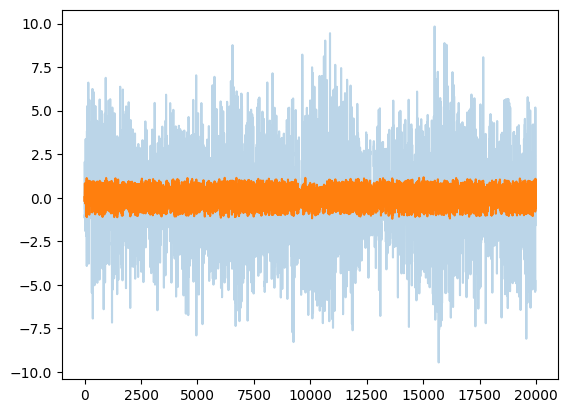

Epoch[2/5] | loss train:395.541014, val loss:101.544221 | lr:0.001000 | r2: 0.01976|
[ 0.08143491 -0.05920237 -0.05378107 ...  0.16010453  0.11694724
  0.03307621]
[-1.0226028  -1.1629553  -0.21784385 ...  0.4590445  -0.62965107
 -1.5678278 ]


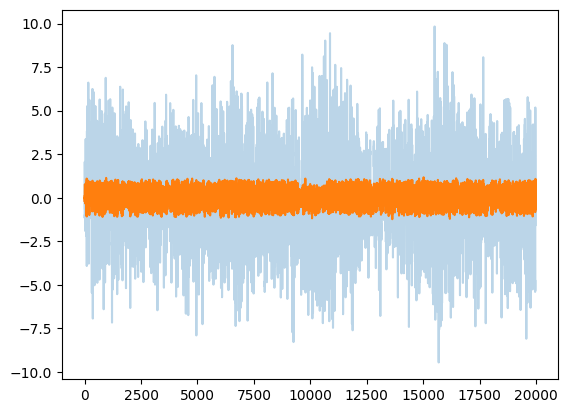

Epoch[3/5] | loss train:394.999361, val loss:101.449785 | lr:0.001000 | r2: 0.02071|
[ 0.11570907 -0.05039459 -0.02879254 ...  0.17276905  0.12974626
  0.03977756]
[-1.0226028  -1.1629553  -0.21784385 ...  0.4590445  -0.62965107
 -1.5678278 ]


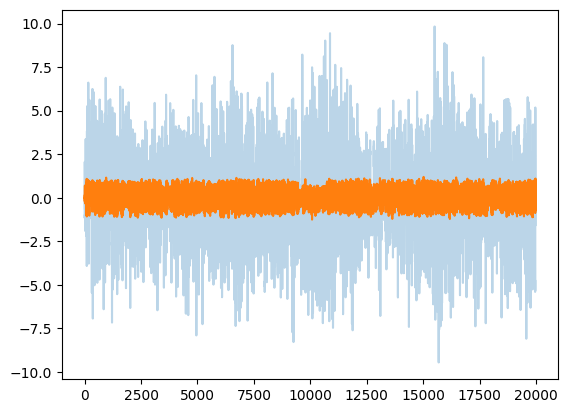

Epoch[4/5] | loss train:394.251829, val loss:101.359345 | lr:0.001000 | r2: 0.02157|
[ 0.16816388 -0.03576643 -0.00483816 ...  0.194868    0.13928324
  0.00929458]
[-1.0226028  -1.1629553  -0.21784385 ...  0.4590445  -0.62965107
 -1.5678278 ]


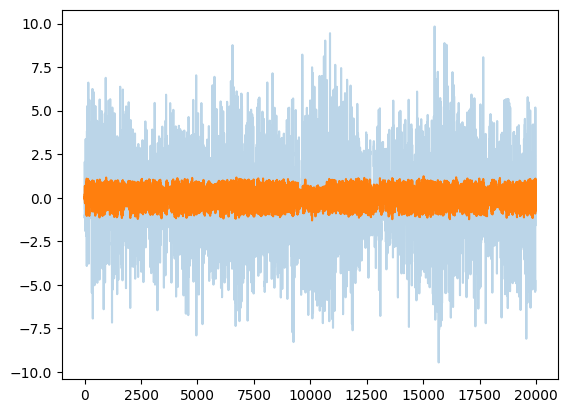

Epoch[5/5] | loss train:393.864538, val loss:101.315599 | lr:0.001000 | r2: 0.02200|
Done with prediction len 7.
Train data shape (79913, 100, 38) (79913,)
Validation data shape (19979, 100, 38) (19979,)
[-0.01599183 -0.05088636 -0.06244031 ...  0.1462536   0.017671
 -0.03924733]
[-0.8291035  -0.55633503  0.51365286 ... -0.17398448 -1.4761289
 -2.80573   ]


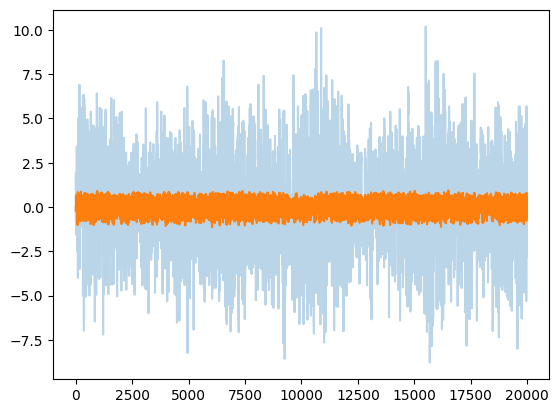

Epoch[1/5] | loss train:403.281277, val loss:101.508836 | lr:0.001000 | r2: 0.01608|
[ 0.03898177 -0.02802532 -0.03857733 ...  0.09032182  0.02327831
 -0.03474206]
[-0.8291035  -0.55633503  0.51365286 ... -0.17398448 -1.4761289
 -2.80573   ]


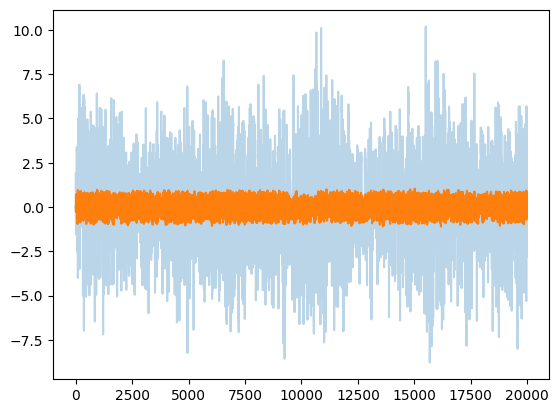

Epoch[2/5] | loss train:400.661546, val loss:101.340643 | lr:0.001000 | r2: 0.01783|
[ 0.06682514 -0.02723473 -0.02365355 ...  0.0904078   0.05259247
 -0.03110979]
[-0.8291035  -0.55633503  0.51365286 ... -0.17398448 -1.4761289
 -2.80573   ]


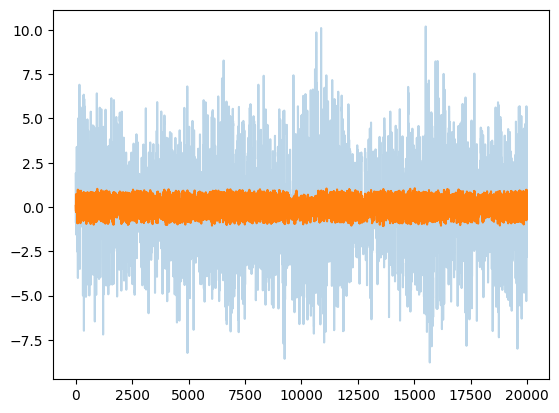

Epoch[3/5] | loss train:400.080741, val loss:101.282427 | lr:0.001000 | r2: 0.01842|
[ 0.08337303 -0.02065572 -0.00917588 ...  0.10819283  0.0743944
 -0.04384257]
[-0.8291035  -0.55633503  0.51365286 ... -0.17398448 -1.4761289
 -2.80573   ]


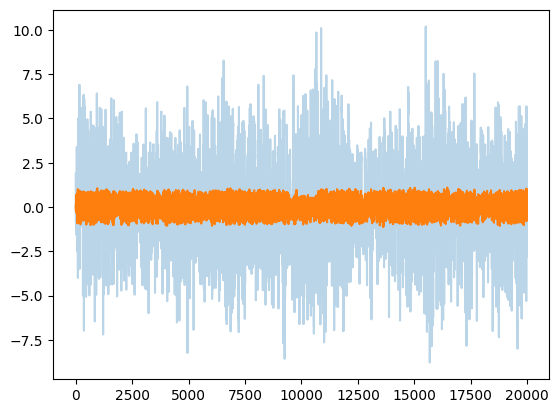

Epoch[4/5] | loss train:399.220966, val loss:101.202307 | lr:0.001000 | r2: 0.01921|
[ 0.1228363  -0.02143594  0.00085149 ...  0.12979162  0.0724358
 -0.06527655]
[-0.8291035  -0.55633503  0.51365286 ... -0.17398448 -1.4761289
 -2.80573   ]


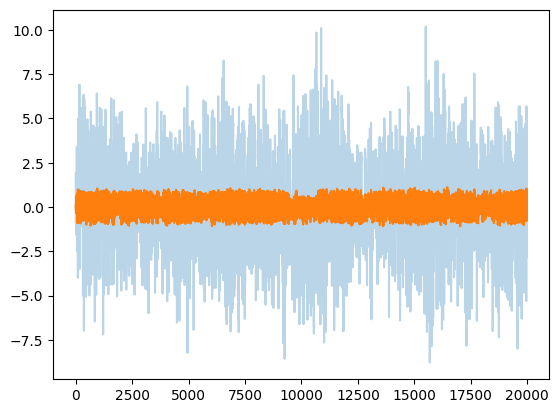

Epoch[5/5] | loss train:399.173556, val loss:101.164127 | lr:0.001000 | r2: 0.01960|
Done with prediction len 8.
Train data shape (79912, 100, 38) (79912,)
Validation data shape (19979, 100, 38) (19979,)
[-0.03128321 -0.06748172 -0.07768888 ...  0.23611614  0.10582599
  0.05371936]
[-0.28180587  0.1513379   1.1311148  ... -0.9998205  -2.6524866
 -2.707109  ]


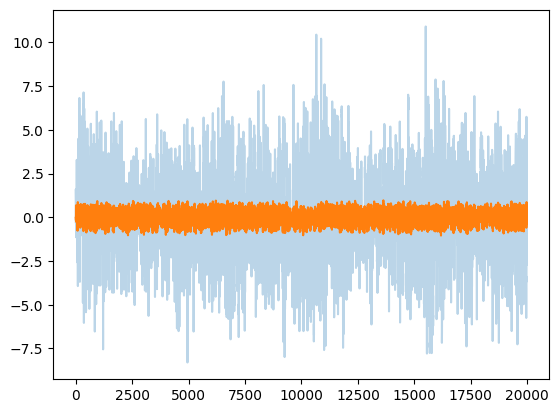

Epoch[1/5] | loss train:408.742630, val loss:101.520158 | lr:0.001000 | r2: 0.01201|
[ 0.04517518 -0.04092314 -0.04730784 ...  0.15252116  0.05626374
  0.00138114]
[-0.28180587  0.1513379   1.1311148  ... -0.9998205  -2.6524866
 -2.707109  ]


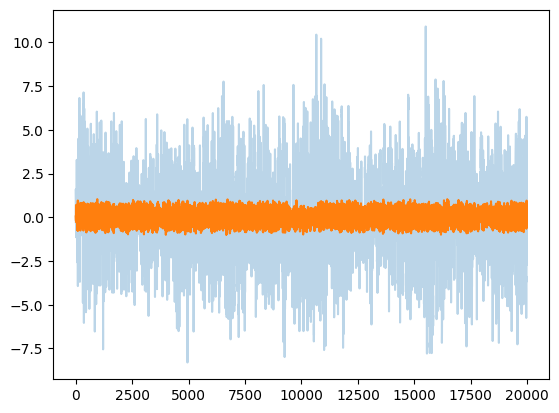

Epoch[2/5] | loss train:405.536062, val loss:101.121837 | lr:0.001000 | r2: 0.01586|
[ 0.06635974 -0.0357128  -0.03250874 ...  0.17039074  0.06779875
 -0.00512069]
[-0.28180587  0.1513379   1.1311148  ... -0.9998205  -2.6524866
 -2.707109  ]


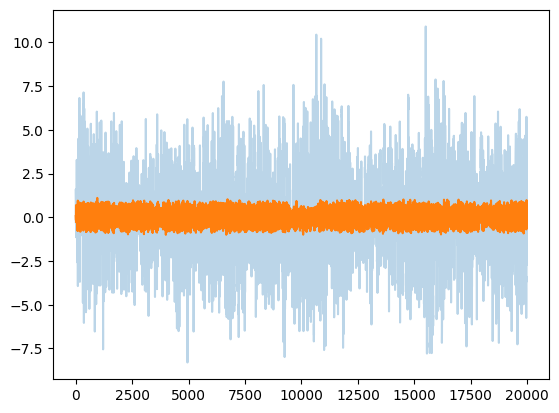

Epoch[3/5] | loss train:404.568798, val loss:101.028113 | lr:0.001000 | r2: 0.01678|
[ 0.08919614 -0.03813172 -0.02971968 ...  0.21610975  0.11519084
  0.00821587]
[-0.28180587  0.1513379   1.1311148  ... -0.9998205  -2.6524866
 -2.707109  ]


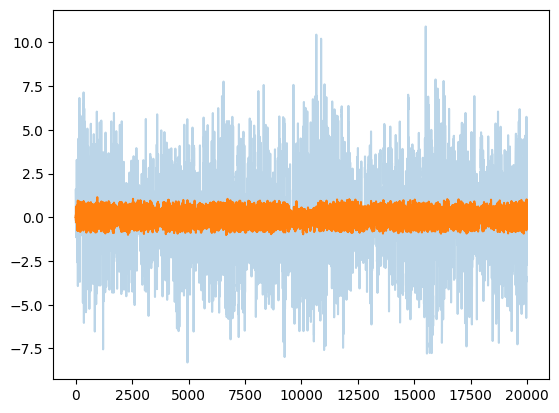

Epoch[4/5] | loss train:404.147629, val loss:100.960252 | lr:0.001000 | r2: 0.01751|
[ 0.11521681 -0.0280047  -0.00897932 ...  0.23923805  0.107944
 -0.00971311]
[-0.28180587  0.1513379   1.1311148  ... -0.9998205  -2.6524866
 -2.707109  ]


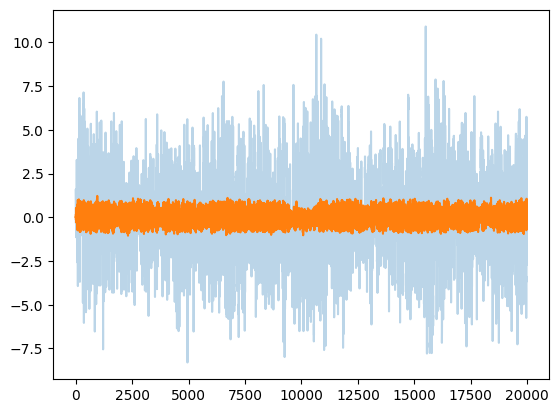

Epoch[5/5] | loss train:403.761488, val loss:100.938462 | lr:0.001000 | r2: 0.01765|
Done with prediction len 9.
Train data shape (79912, 100, 38) (79912,)
Validation data shape (19978, 100, 38) (19978,)
[-0.09315061 -0.09805204 -0.10639563 ...  0.2828362   0.1545531
  0.06785125]
[ 0.7568271  1.2986009  1.2319698 ... -2.1435192 -2.5751495 -2.8494422]


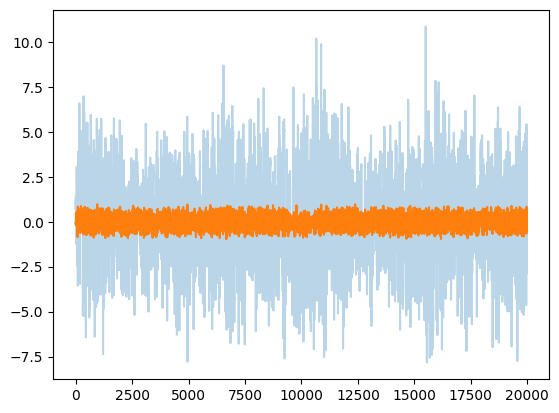

Epoch[1/5] | loss train:412.126112, val loss:101.438229 | lr:0.001000 | r2: 0.01011|
[-0.05021708 -0.05820496 -0.06197312 ...  0.13583232  0.05858161
  0.01494149]
[ 0.7568271  1.2986009  1.2319698 ... -2.1435192 -2.5751495 -2.8494422]


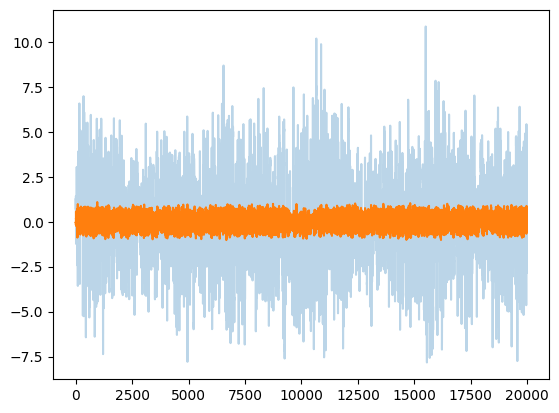

Epoch[2/5] | loss train:408.900887, val loss:101.069371 | lr:0.001000 | r2: 0.01370|
[-0.04443347 -0.04528192 -0.04855993 ...  0.12026916  0.0646562
  0.02430163]
[ 0.7568271  1.2986009  1.2319698 ... -2.1435192 -2.5751495 -2.8494422]


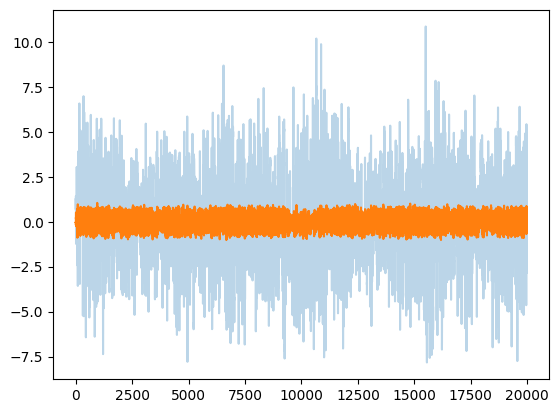

Epoch[3/5] | loss train:408.254054, val loss:100.978238 | lr:0.001000 | r2: 0.01460|
[-0.04734042 -0.0403643  -0.04050052 ...  0.10887393  0.04204689
 -0.00512419]
[ 0.7568271  1.2986009  1.2319698 ... -2.1435192 -2.5751495 -2.8494422]


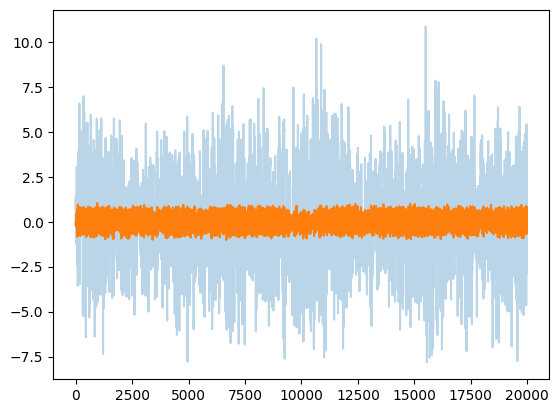

Epoch[4/5] | loss train:407.699726, val loss:100.900207 | lr:0.001000 | r2: 0.01541|
[-0.02473032 -0.00053859  0.00397444 ...  0.12279453  0.05473158
  0.00106872]
[ 0.7568271  1.2986009  1.2319698 ... -2.1435192 -2.5751495 -2.8494422]


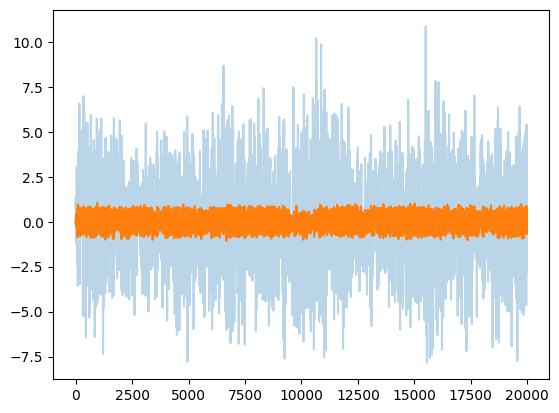

Epoch[5/5] | loss train:407.294800, val loss:100.896976 | lr:0.001000 | r2: 0.01544|
Done with prediction len 10.
Train data shape (79911, 100, 38) (79911,)
Validation data shape (19978, 100, 38) (19978,)
[-0.02211327 -0.02901609 -0.03118284 ...  0.21693842  0.11434563
  0.05443178]
[ 0.93683124  0.96625465  0.98252106 ... -2.1003857  -2.7232702
 -2.3970294 ]


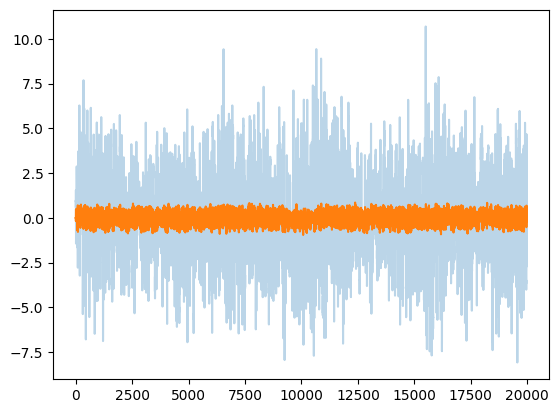

Epoch[1/5] | loss train:414.354619, val loss:101.314771 | lr:0.001000 | r2: 0.00793|
[-0.02703749 -0.03790295 -0.035004   ...  0.1192961   0.05018946
  0.00100192]
[ 0.93683124  0.96625465  0.98252106 ... -2.1003857  -2.7232702
 -2.3970294 ]


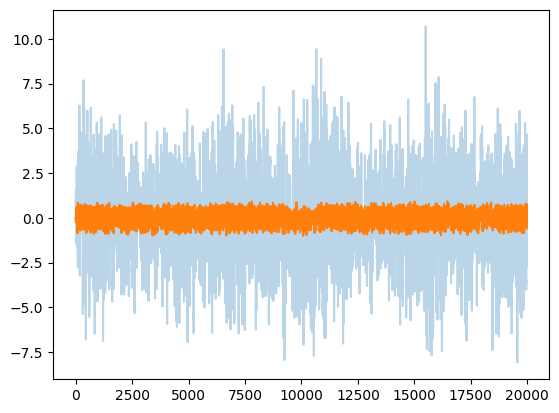

Epoch[2/5] | loss train:411.653047, val loss:101.003976 | lr:0.001000 | r2: 0.01103|
[-0.01497236 -0.02709047 -0.0302911  ...  0.1394828   0.06582157
 -0.02470073]
[ 0.93683124  0.96625465  0.98252106 ... -2.1003857  -2.7232702
 -2.3970294 ]


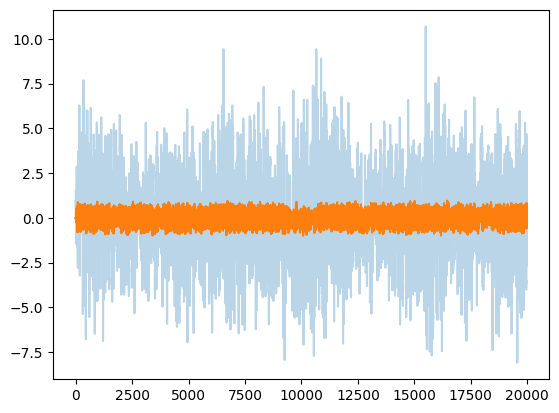

Epoch[3/5] | loss train:410.839082, val loss:100.911508 | lr:0.001000 | r2: 0.01191|
[-0.02812678 -0.03785229 -0.03881686 ...  0.12589103  0.06372369
 -0.01442845]
[ 0.93683124  0.96625465  0.98252106 ... -2.1003857  -2.7232702
 -2.3970294 ]


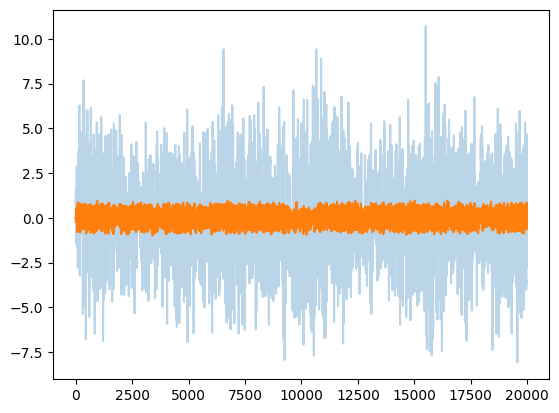

Epoch[4/5] | loss train:410.423488, val loss:100.822216 | lr:0.001000 | r2: 0.01281|
[-0.00596782 -0.01643037 -0.01842528 ...  0.15606634  0.08120711
 -0.03305813]
[ 0.93683124  0.96625465  0.98252106 ... -2.1003857  -2.7232702
 -2.3970294 ]


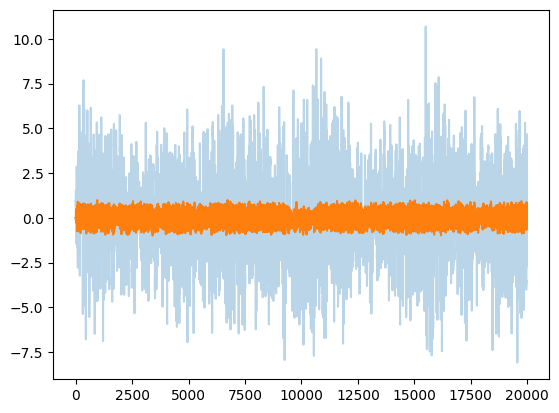

Epoch[5/5] | loss train:410.085400, val loss:100.796907 | lr:0.001000 | r2: 0.01306|
Done with prediction len 11.
Train data shape (79910, 100, 38) (79910,)
Validation data shape (19978, 100, 38) (19978,)
[-0.05736024 -0.06208352 -0.06490684 ...  0.24499062  0.16834557
  0.11093064]
[ 0.6373962  0.7417478  0.5179832 ... -2.26777   -2.301688  -1.2820569]


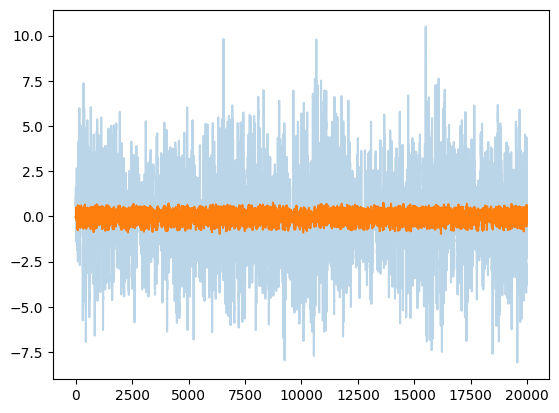

Epoch[1/5] | loss train:415.862019, val loss:100.846530 | lr:0.001000 | r2: 0.00844|
[-0.05376131 -0.0583069  -0.06218575 ...  0.09014297  0.03518797
  0.02707813]
[ 0.6373962  0.7417478  0.5179832 ... -2.26777   -2.301688  -1.2820569]


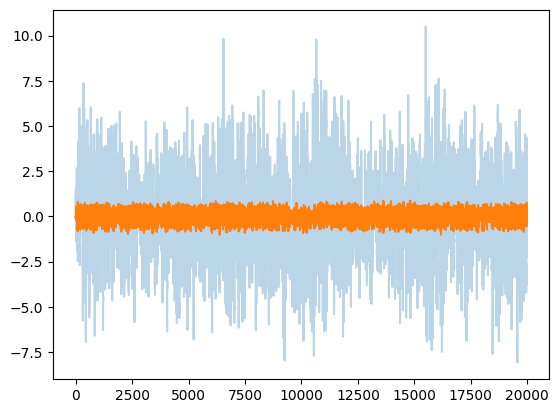

Epoch[2/5] | loss train:413.102618, val loss:100.581632 | lr:0.001000 | r2: 0.01105|
[-0.05619391 -0.05590502 -0.05904093 ...  0.04720248  0.01154081
  0.01605115]
[ 0.6373962  0.7417478  0.5179832 ... -2.26777   -2.301688  -1.2820569]


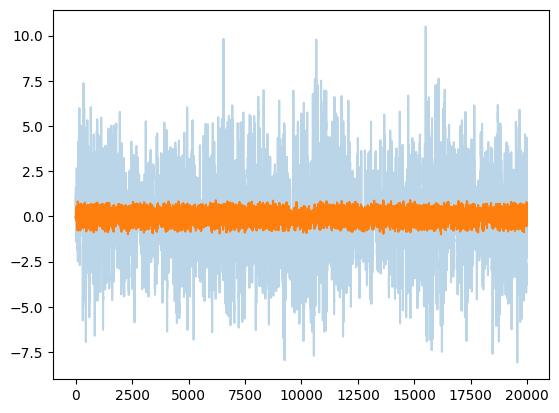

Epoch[3/5] | loss train:412.494823, val loss:100.507456 | lr:0.001000 | r2: 0.01182|
[-0.04583425 -0.04789631 -0.05473081 ...  0.02681737  0.01950288
 -0.00550842]
[ 0.6373962  0.7417478  0.5179832 ... -2.26777   -2.301688  -1.2820569]


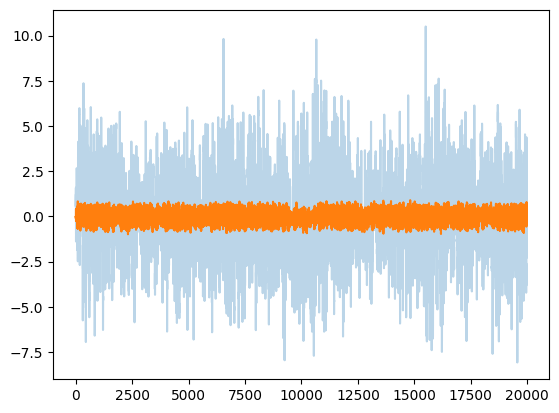

Epoch[4/5] | loss train:412.129174, val loss:100.453328 | lr:0.001000 | r2: 0.01241|
[-0.03136171 -0.02527883 -0.03267483 ... -0.01373569 -0.03750458
 -0.05576751]
[ 0.6373962  0.7417478  0.5179832 ... -2.26777   -2.301688  -1.2820569]


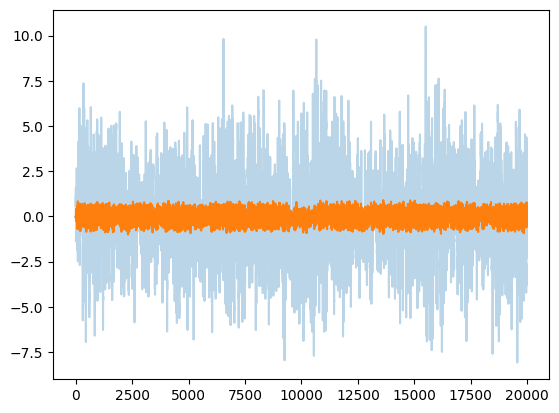

Epoch[5/5] | loss train:411.812527, val loss:100.423404 | lr:0.001000 | r2: 0.01272|
Done with prediction len 12.
Train data shape (79909, 100, 38) (79909,)
Validation data shape (19978, 100, 38) (19978,)
[-0.05408011 -0.06838006 -0.0798365  ...  0.15624842  0.04989362
  0.01955392]
[ 0.43682435  0.30731407  0.35543025 ... -1.8860539  -1.2395252
 -0.11048298]


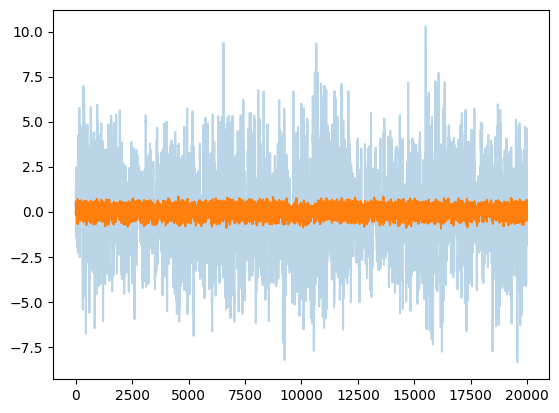

Epoch[1/5] | loss train:416.502349, val loss:100.496305 | lr:0.001000 | r2: 0.00843|
[-0.05758322 -0.06851519 -0.08127198 ...  0.05827754 -0.01236651
 -0.0283571 ]
[ 0.43682435  0.30731407  0.35543025 ... -1.8860539  -1.2395252
 -0.11048298]


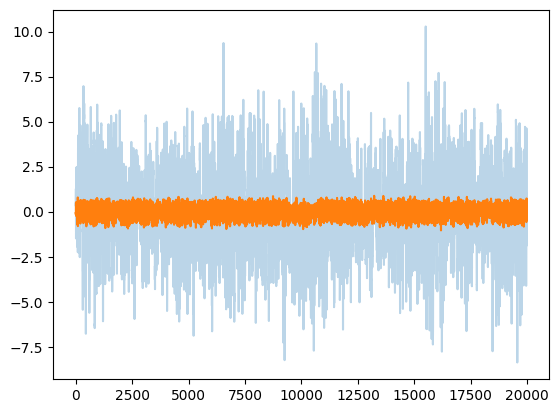

Epoch[2/5] | loss train:413.951848, val loss:100.287118 | lr:0.001000 | r2: 0.01050|
[-0.04310434 -0.05111434 -0.06783862 ...  0.02232071 -0.03573451
 -0.07119776]
[ 0.43682435  0.30731407  0.35543025 ... -1.8860539  -1.2395252
 -0.11048298]


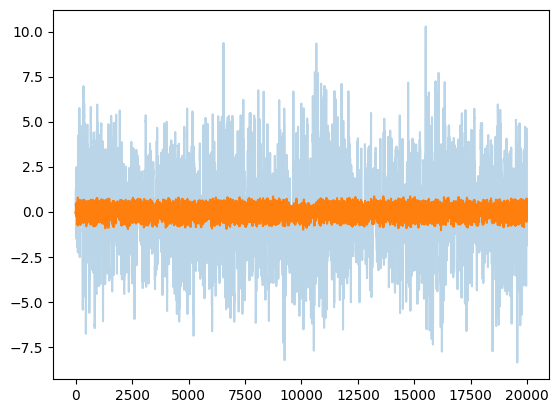

Epoch[3/5] | loss train:413.442502, val loss:100.182418 | lr:0.001000 | r2: 0.01151|
[-0.03358845 -0.03893933 -0.06676503 ...  0.02676953 -0.01433365
 -0.05763195]
[ 0.43682435  0.30731407  0.35543025 ... -1.8860539  -1.2395252
 -0.11048298]


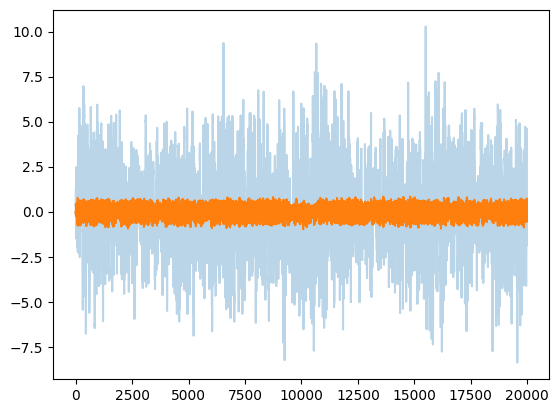

Epoch[4/5] | loss train:413.109141, val loss:100.127852 | lr:0.001000 | r2: 0.01214|
[-0.01266013 -0.0240682  -0.04462026 ...  0.01595828 -0.05292837
 -0.1278743 ]
[ 0.43682435  0.30731407  0.35543025 ... -1.8860539  -1.2395252
 -0.11048298]


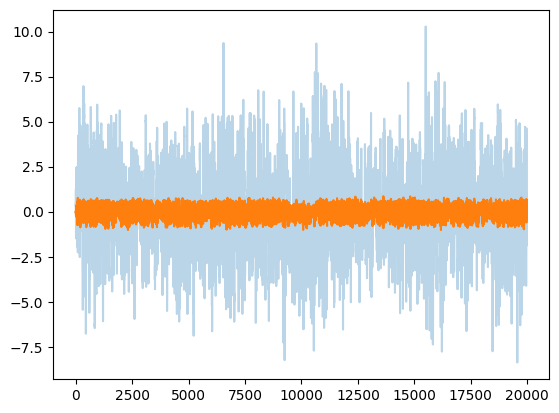

Epoch[5/5] | loss train:412.493822, val loss:100.096057 | lr:0.001000 | r2: 0.01243|
Done with prediction len 13.
Train data shape (79908, 100, 38) (79908,)
Validation data shape (19978, 100, 38) (19978,)
[-0.07513522 -0.08661582 -0.06540156 ...  0.20935662  0.12996198
  0.0770331 ]
[ 0.03116244  0.15948315  0.48744518 ... -0.8825303  -0.11528604
  0.70074743]


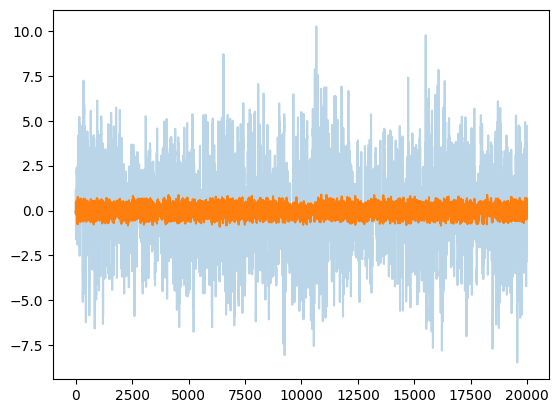

Epoch[1/5] | loss train:416.600578, val loss:100.169653 | lr:0.001000 | r2: 0.00754|
[-0.0785284  -0.08926339 -0.07465732 ...  0.10756116  0.03384447
  0.01092949]
[ 0.03116244  0.15948315  0.48744518 ... -0.8825303  -0.11528604
  0.70074743]


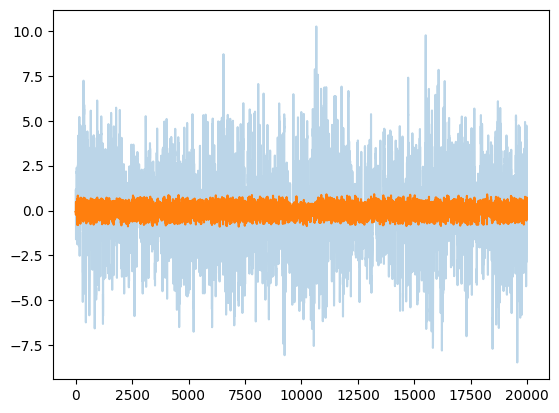

Epoch[2/5] | loss train:414.645897, val loss:99.987035 | lr:0.001000 | r2: 0.00940|
[-0.09566168 -0.10351093 -0.09681536 ...  0.11286376  0.04700615
  0.00629419]
[ 0.03116244  0.15948315  0.48744518 ... -0.8825303  -0.11528604
  0.70074743]


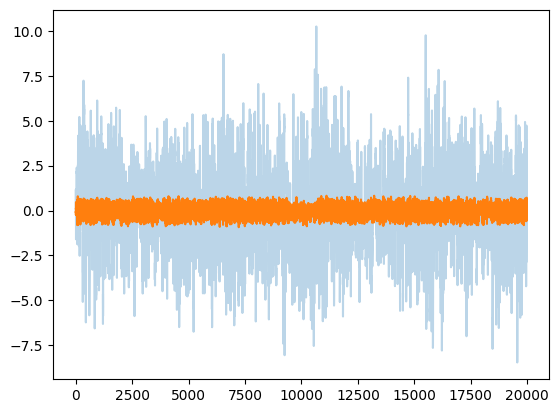

Epoch[3/5] | loss train:414.181445, val loss:99.913098 | lr:0.001000 | r2: 0.01010|
[-0.07813387 -0.07756682 -0.06805341 ...  0.05456577 -0.00963322
 -0.04798366]
[ 0.03116244  0.15948315  0.48744518 ... -0.8825303  -0.11528604
  0.70074743]


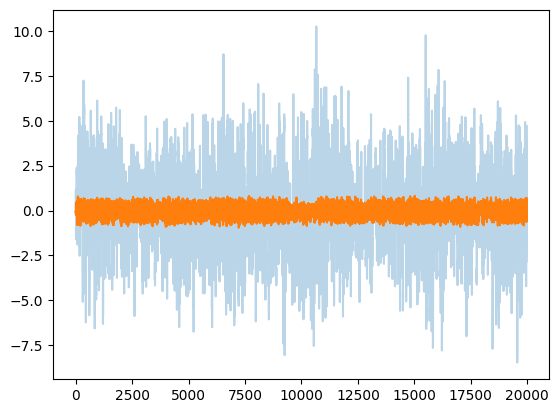

Epoch[4/5] | loss train:413.753066, val loss:99.861096 | lr:0.001000 | r2: 0.01069|
[-0.1083361  -0.10274486 -0.09550911 ...  0.09958144  0.04981089
 -0.01788432]
[ 0.03116244  0.15948315  0.48744518 ... -0.8825303  -0.11528604
  0.70074743]


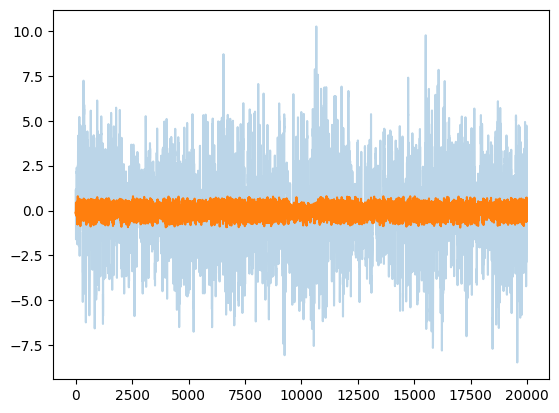

Epoch[5/5] | loss train:413.497050, val loss:99.839141 | lr:0.001000 | r2: 0.01088|
Done with prediction len 14.
Train data shape (79908, 100, 38) (79908,)
Validation data shape (19977, 100, 38) (19977,)
[-0.0439693  -0.05244925 -0.03455953 ...  0.22466406  0.14621687
  0.11368347]
[0.2941609  0.80939335 1.1301093  ... 0.18835469 0.66756964 1.2498825 ]


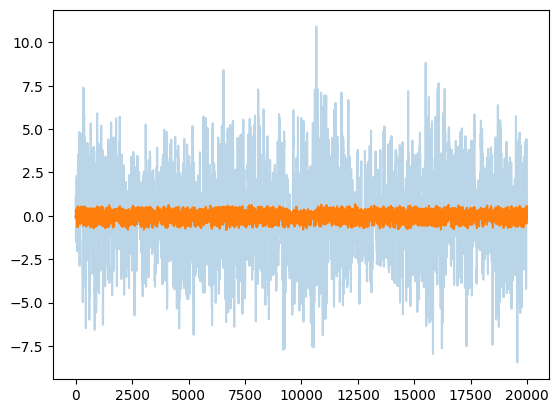

Epoch[1/5] | loss train:417.384828, val loss:99.957921 | lr:0.001000 | r2: 0.00499|
[-0.04581492 -0.0617224  -0.03251854 ...  0.09927994  0.02874688
  0.00404914]
[0.2941609  0.80939335 1.1301093  ... 0.18835469 0.66756964 1.2498825 ]


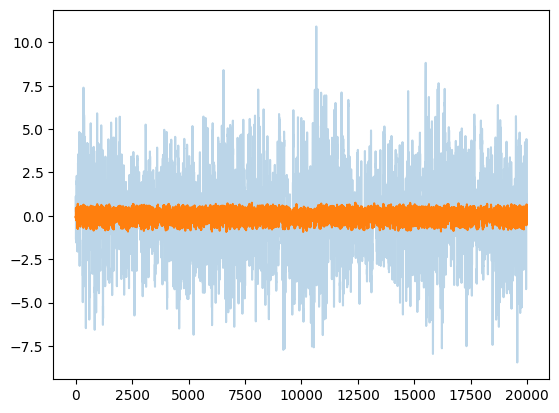

Epoch[2/5] | loss train:415.125436, val loss:99.754046 | lr:0.001000 | r2: 0.00697|
[-0.05049965 -0.05754905 -0.0237064  ...  0.0732825   0.00975349
 -0.01767312]
[0.2941609  0.80939335 1.1301093  ... 0.18835469 0.66756964 1.2498825 ]


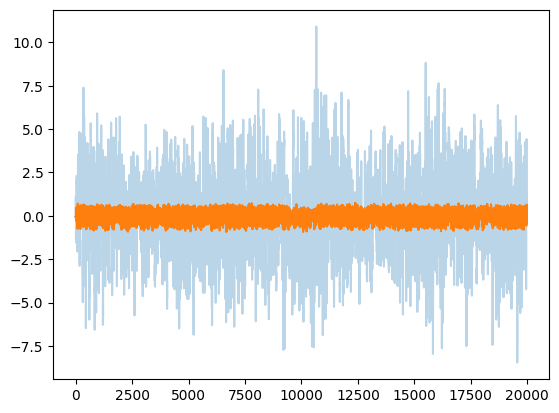

Epoch[3/5] | loss train:414.494470, val loss:99.662749 | lr:0.001000 | r2: 0.00792|
[-0.0765567  -0.09234452 -0.04750961 ...  0.01350689 -0.02468211
 -0.06355987]
[0.2941609  0.80939335 1.1301093  ... 0.18835469 0.66756964 1.2498825 ]


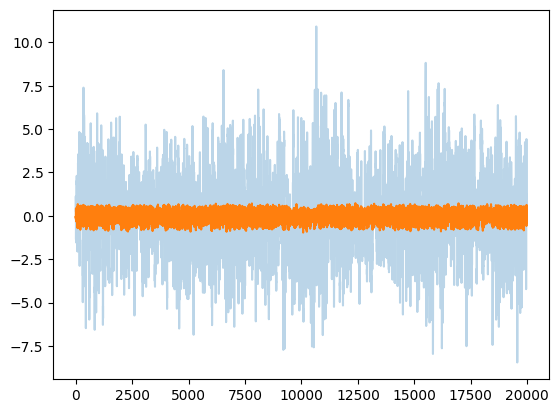

Epoch[4/5] | loss train:414.137235, val loss:99.587575 | lr:0.001000 | r2: 0.00873|
[-0.0529478  -0.06455645 -0.02129005 ...  0.04921027  0.00052609
 -0.0712436 ]
[0.2941609  0.80939335 1.1301093  ... 0.18835469 0.66756964 1.2498825 ]


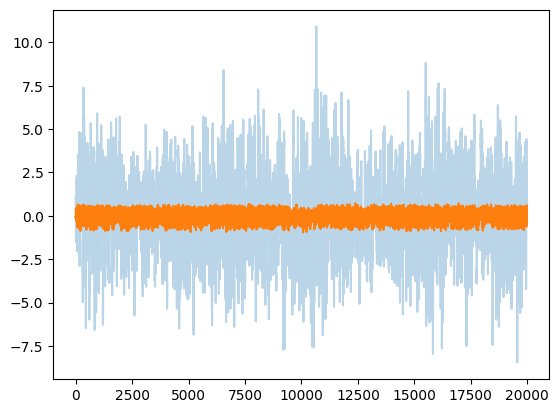

Epoch[5/5] | loss train:413.903815, val loss:99.523946 | lr:0.001000 | r2: 0.00936|
Done with prediction len 15.
Train data shape (79907, 100, 38) (79907,)
Validation data shape (19977, 100, 38) (19977,)
[-0.06984311 -0.07506853 -0.0589156  ...  0.24545456  0.15820387
  0.11838911]
[0.61239135 0.93806505 0.8642807  ... 0.9354176  1.2004927  1.790716  ]


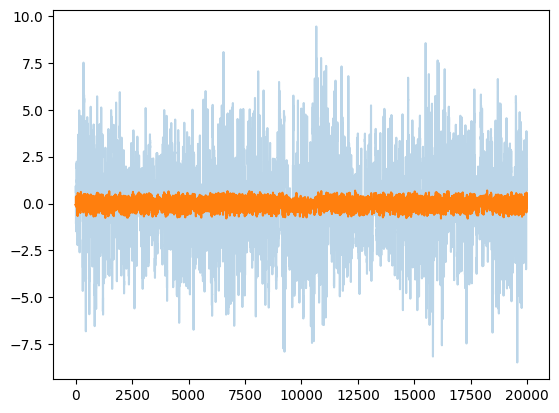

Epoch[1/5] | loss train:417.167076, val loss:99.280068 | lr:0.001000 | r2: 0.00613|
[-0.05368171 -0.05405871 -0.02800102 ...  0.08482903  0.0313363
  0.01679106]
[0.61239135 0.93806505 0.8642807  ... 0.9354176  1.2004927  1.790716  ]


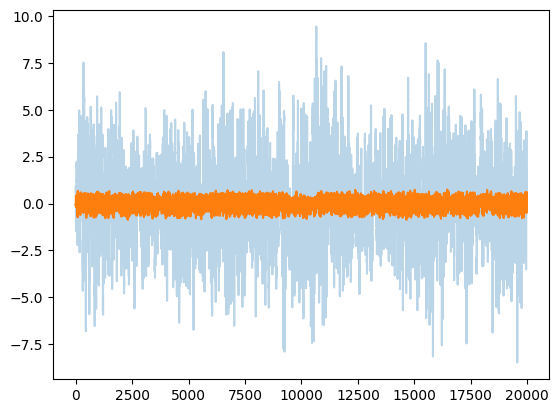

Epoch[2/5] | loss train:415.316172, val loss:99.068514 | lr:0.001000 | r2: 0.00829|
[-0.07251056 -0.07682848 -0.0486663  ...  0.08727343  0.04591761
  0.05331682]
[0.61239135 0.93806505 0.8642807  ... 0.9354176  1.2004927  1.790716  ]


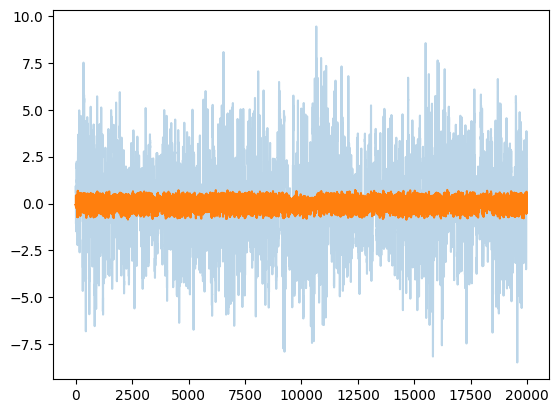

Epoch[3/5] | loss train:414.815122, val loss:99.023651 | lr:0.001000 | r2: 0.00876|
[-8.4973715e-02 -8.6816631e-02 -5.5536766e-02 ...  9.2134560e-03
 -6.8078749e-05 -1.0467186e-02]
[0.61239135 0.93806505 0.8642807  ... 0.9354176  1.2004927  1.790716  ]


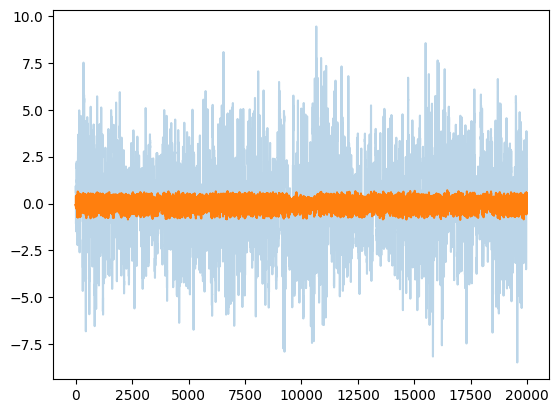

Epoch[4/5] | loss train:414.571317, val loss:98.954560 | lr:0.001000 | r2: 0.00953|
[-0.08383627 -0.0857886  -0.0523833  ...  0.06092712  0.02512575
  0.01395512]
[0.61239135 0.93806505 0.8642807  ... 0.9354176  1.2004927  1.790716  ]


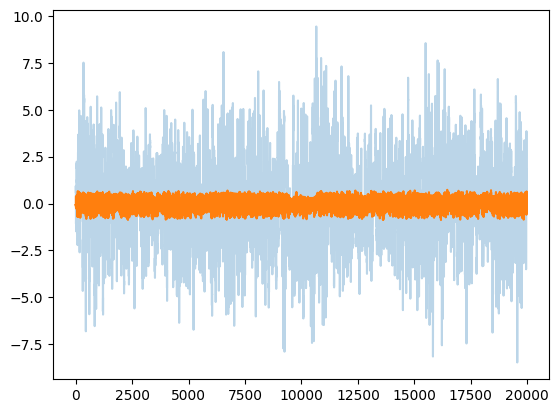

Epoch[5/5] | loss train:414.309408, val loss:98.966923 | lr:0.001000 | r2: 0.00939|
Done with prediction len 16.
Train data shape (79906, 100, 38) (79906,)
Validation data shape (19977, 100, 38) (19977,)
[-0.05485468 -0.06421232 -0.04690509 ...  0.2042718   0.15172991
  0.12741229]
[0.7439148  0.68741983 0.5140012  ... 1.4442041  1.7272815  1.8367413 ]


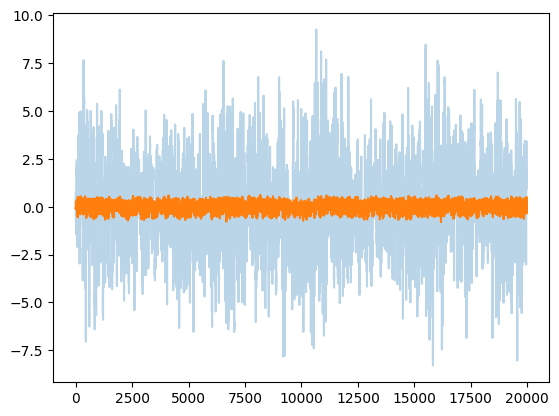

Epoch[1/5] | loss train:417.467425, val loss:98.799790 | lr:0.001000 | r2: 0.00579|
[-0.08928169 -0.09693196 -0.07580253 ...  0.11591376  0.06941469
  0.0561837 ]
[0.7439148  0.68741983 0.5140012  ... 1.4442041  1.7272815  1.8367413 ]


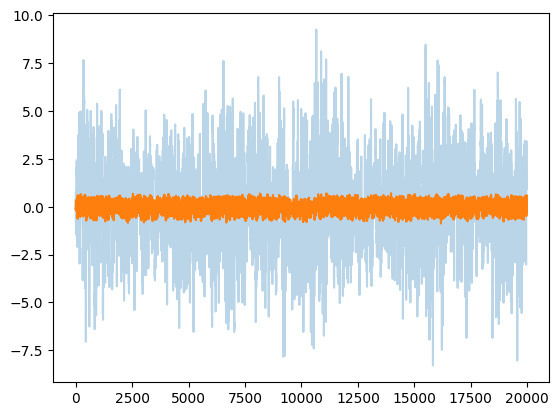

Epoch[2/5] | loss train:415.697523, val loss:98.702013 | lr:0.001000 | r2: 0.00678|
[-0.11196168 -0.12001197 -0.09178781 ...  0.09206182  0.06257312
  0.05610191]
[0.7439148  0.68741983 0.5140012  ... 1.4442041  1.7272815  1.8367413 ]


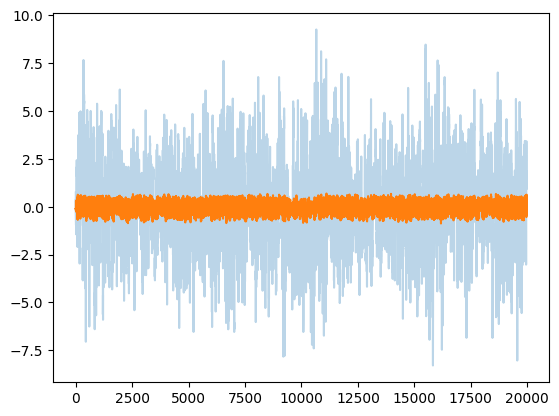

Epoch[3/5] | loss train:415.167658, val loss:98.639331 | lr:0.001000 | r2: 0.00747|
[-0.1132036  -0.12066314 -0.08874048 ...  0.0347426   0.00883985
  0.00800249]
[0.7439148  0.68741983 0.5140012  ... 1.4442041  1.7272815  1.8367413 ]


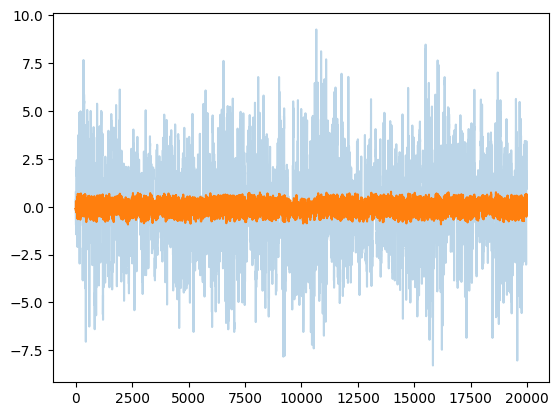

Epoch[4/5] | loss train:414.767958, val loss:98.630858 | lr:0.001000 | r2: 0.00761|
[-0.10894947 -0.11586986 -0.08212543 ...  0.03029755  0.00525112
 -0.00647175]
[0.7439148  0.68741983 0.5140012  ... 1.4442041  1.7272815  1.8367413 ]


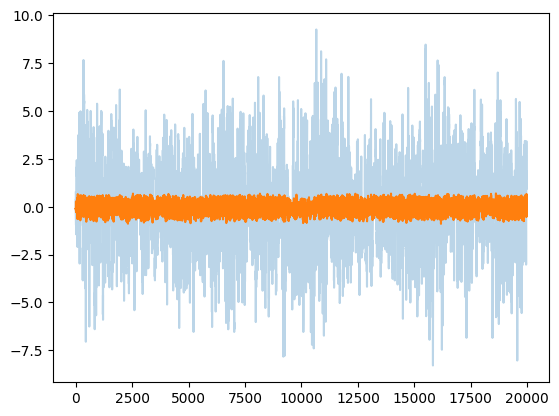

Epoch[5/5] | loss train:414.761142, val loss:98.581321 | lr:0.001000 | r2: 0.00807|
Done with prediction len 17.
Train data shape (79905, 100, 38) (79905,)
Validation data shape (19977, 100, 38) (19977,)
[-0.07673925 -0.08614977 -0.07029782 ...  0.232464    0.1826002
  0.13372922]
[0.507014  0.3532287 0.3825626 ... 1.9494735 1.775266  1.3942208]


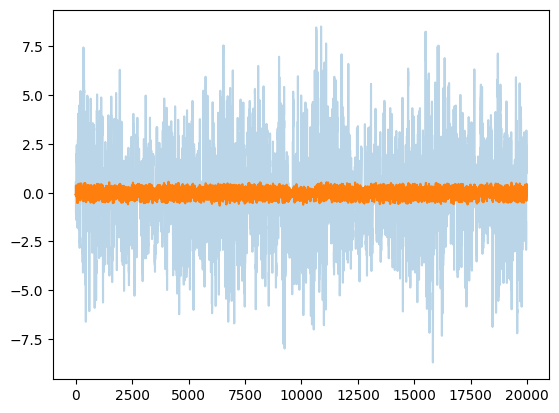

Epoch[1/5] | loss train:417.572695, val loss:98.446990 | lr:0.001000 | r2: 0.00458|
[-0.10285038 -0.11380501 -0.09190622 ...  0.15737945  0.11531316
  0.08130749]
[0.507014  0.3532287 0.3825626 ... 1.9494735 1.775266  1.3942208]


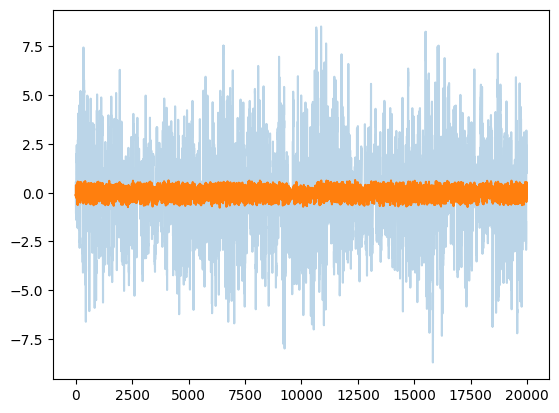

Epoch[2/5] | loss train:416.012607, val loss:98.322454 | lr:0.001000 | r2: 0.00590|
[-0.10243206 -0.11725499 -0.09130992 ...  0.1260879   0.1005484
  0.07881917]
[0.507014  0.3532287 0.3825626 ... 1.9494735 1.775266  1.3942208]


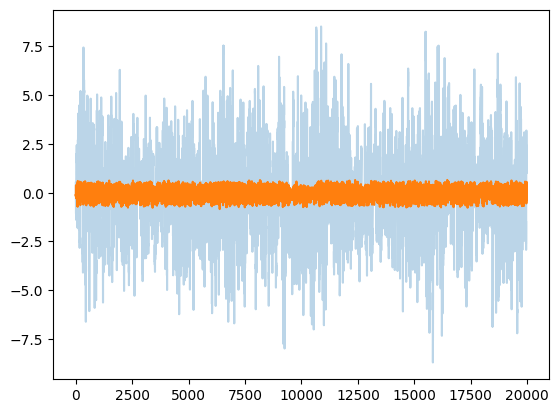

Epoch[3/5] | loss train:415.244694, val loss:98.236068 | lr:0.001000 | r2: 0.00677|
[-0.11297371 -0.12605473 -0.09732223 ...  0.09773321  0.07526483
  0.05830138]
[0.507014  0.3532287 0.3825626 ... 1.9494735 1.775266  1.3942208]


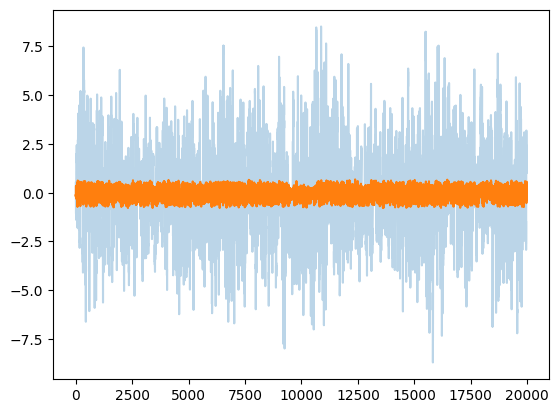

Epoch[4/5] | loss train:415.082258, val loss:98.203443 | lr:0.001000 | r2: 0.00715|
[-0.09747076 -0.11824792 -0.08638063 ...  0.10333661  0.08049886
  0.0455755 ]
[0.507014  0.3532287 0.3825626 ... 1.9494735 1.775266  1.3942208]


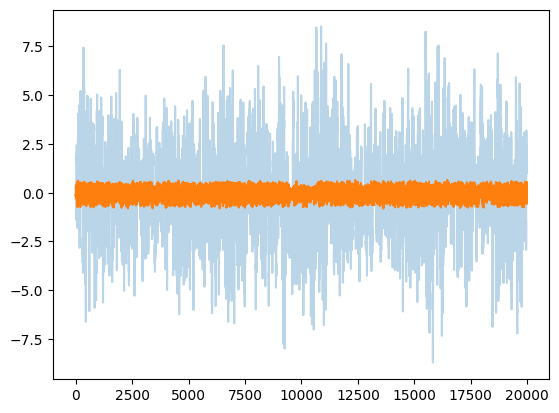

Epoch[5/5] | loss train:414.715630, val loss:98.137192 | lr:0.001000 | r2: 0.00773|
Done with prediction len 18.
Train data shape (79904, 100, 38) (79904,)
Validation data shape (19977, 100, 38) (19977,)
[-0.10992303 -0.11227565 -0.10011346 ...  0.17103997  0.13808575
  0.10887816]
[0.18755417 0.23024464 0.14353617 ... 1.9912337  1.3480147  1.106946  ]


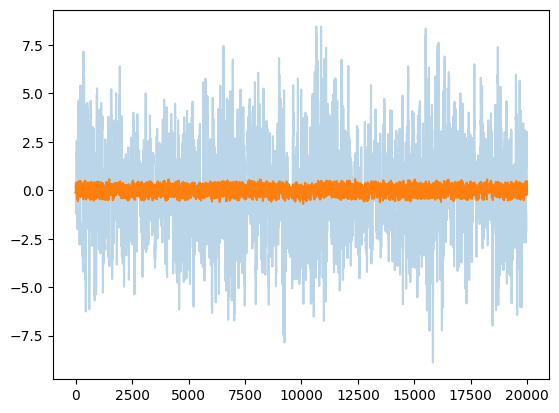

Epoch[1/5] | loss train:418.425141, val loss:98.102773 | lr:0.001000 | r2: 0.00322|
[-0.08318077 -0.08648787 -0.07128392 ...  0.07226777  0.03637942
  0.0290243 ]
[0.18755417 0.23024464 0.14353617 ... 1.9912337  1.3480147  1.106946  ]


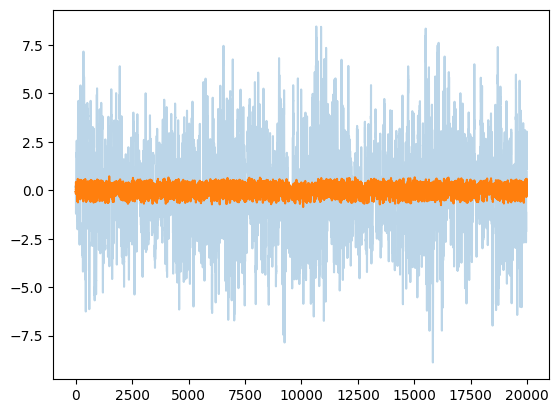

Epoch[2/5] | loss train:416.192498, val loss:97.899027 | lr:0.001000 | r2: 0.00520|
[-0.09959839 -0.10398461 -0.08446406 ...  0.06637065  0.02653468
  0.00430071]
[0.18755417 0.23024464 0.14353617 ... 1.9912337  1.3480147  1.106946  ]


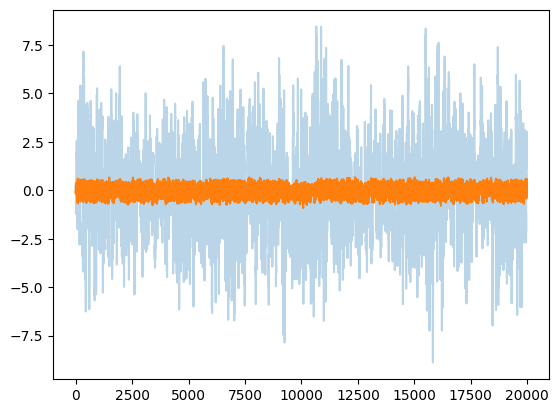

Epoch[3/5] | loss train:415.524160, val loss:97.843484 | lr:0.001000 | r2: 0.00575|
[-0.10459685 -0.10911536 -0.08285813 ... -0.00683307 -0.01296439
 -0.01068186]
[0.18755417 0.23024464 0.14353617 ... 1.9912337  1.3480147  1.106946  ]


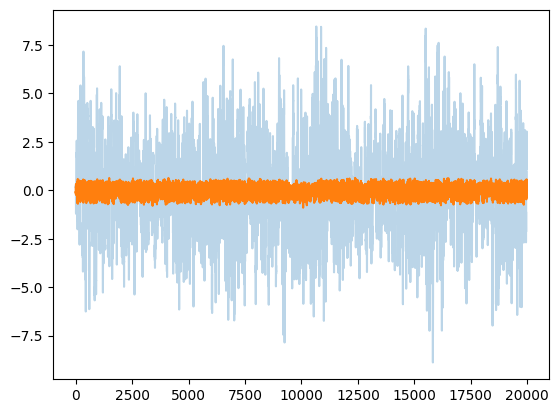

Epoch[4/5] | loss train:415.203999, val loss:97.798472 | lr:0.001000 | r2: 0.00629|
[-0.08927804 -0.09511904 -0.07035792 ...  0.01194468  0.01045911
  0.00567127]
[0.18755417 0.23024464 0.14353617 ... 1.9912337  1.3480147  1.106946  ]


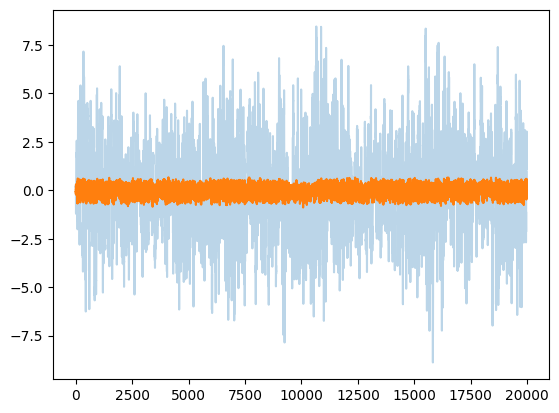

Epoch[5/5] | loss train:415.094364, val loss:97.775537 | lr:0.001000 | r2: 0.00657|
Done with prediction len 19.
Train data shape (79904, 100, 38) (79904,)
Validation data shape (19976, 100, 38) (19976,)
[-0.12420157 -0.10648393 -0.09952624 ...  0.15427387  0.09740836
  0.11747052]
[1.7529277e-03 1.2819096e-01 8.2177762e-03 ... 1.5706884e+00 1.0704105e+00
 1.8723828e+00]


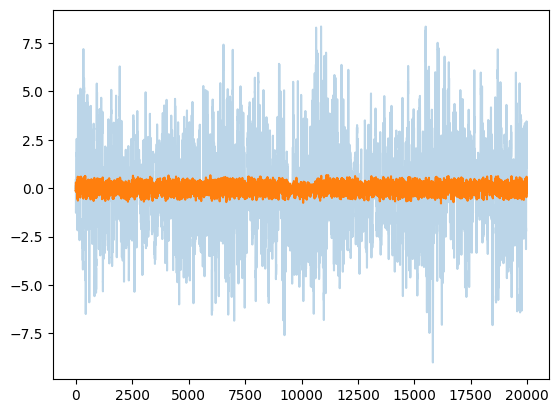

Epoch[1/5] | loss train:417.197909, val loss:97.554616 | lr:0.001000 | r2: 0.00377|
[-0.15072243 -0.13219187 -0.12547067 ...  0.03471188 -0.00506525
  0.03546964]
[1.7529277e-03 1.2819096e-01 8.2177762e-03 ... 1.5706884e+00 1.0704105e+00
 1.8723828e+00]


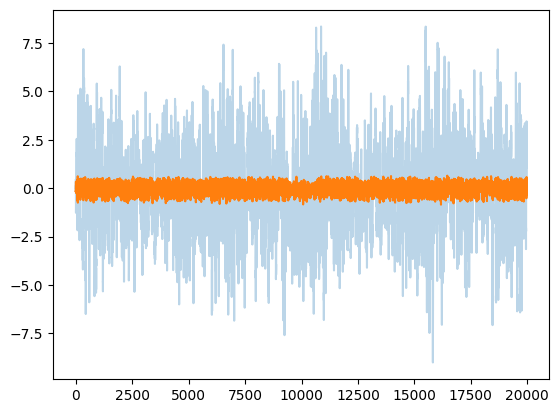

Epoch[2/5] | loss train:415.481556, val loss:97.394817 | lr:0.001000 | r2: 0.00531|
[-0.15159139 -0.12344826 -0.11232968 ...  0.02171    -0.00748379
  0.03239515]
[1.7529277e-03 1.2819096e-01 8.2177762e-03 ... 1.5706884e+00 1.0704105e+00
 1.8723828e+00]


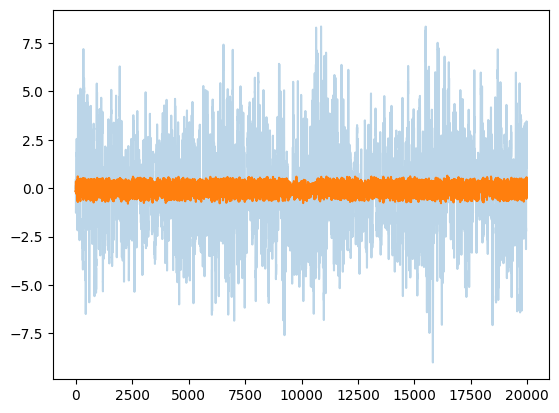

Epoch[3/5] | loss train:415.166157, val loss:97.349424 | lr:0.001000 | r2: 0.00578|
[-0.13795643 -0.10522556 -0.09793124 ... -0.00587807 -0.01875834
  0.03349744]
[1.7529277e-03 1.2819096e-01 8.2177762e-03 ... 1.5706884e+00 1.0704105e+00
 1.8723828e+00]


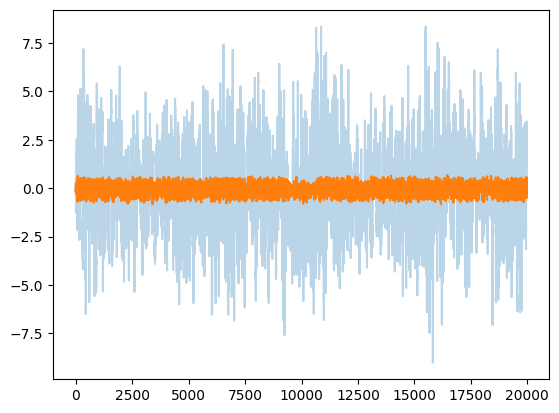

Epoch[4/5] | loss train:414.940274, val loss:97.315464 | lr:0.001000 | r2: 0.00618|
[-0.13125794 -0.09132995 -0.08261581 ...  0.01949067  0.0054216
  0.02610023]
[1.7529277e-03 1.2819096e-01 8.2177762e-03 ... 1.5706884e+00 1.0704105e+00
 1.8723828e+00]


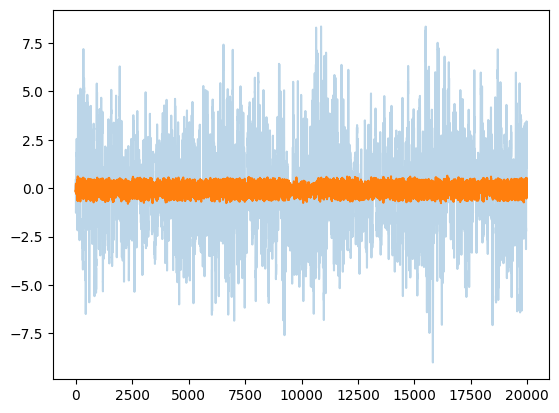

Epoch[5/5] | loss train:414.758158, val loss:97.295531 | lr:0.001000 | r2: 0.00640|
Done with prediction len 20.
Train data shape (79903, 100, 38) (79903,)
Validation data shape (19976, 100, 38) (19976,)
[-0.10636169 -0.09994669 -0.09856509 ...  0.21345054  0.14768116
  0.08102753]
[-0.00957358  0.00682015 -0.12866649 ...  1.2952496   1.8182437
  2.62303   ]


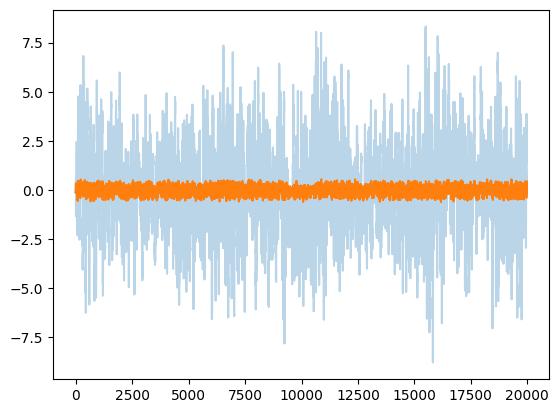

Epoch[1/5] | loss train:417.572160, val loss:97.073481 | lr:0.001000 | r2: 0.00367|
[-0.11870728 -0.10416295 -0.10054287 ...  0.14313142  0.08644708
  0.05468882]
[-0.00957358  0.00682015 -0.12866649 ...  1.2952496   1.8182437
  2.62303   ]


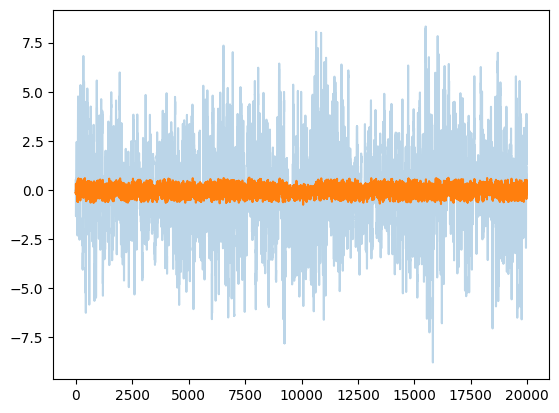

Epoch[2/5] | loss train:415.895195, val loss:96.931655 | lr:0.001000 | r2: 0.00520|
[-0.16393976 -0.14850655 -0.14512414 ...  0.04501145  0.01870127
 -0.00111339]
[-0.00957358  0.00682015 -0.12866649 ...  1.2952496   1.8182437
  2.62303   ]


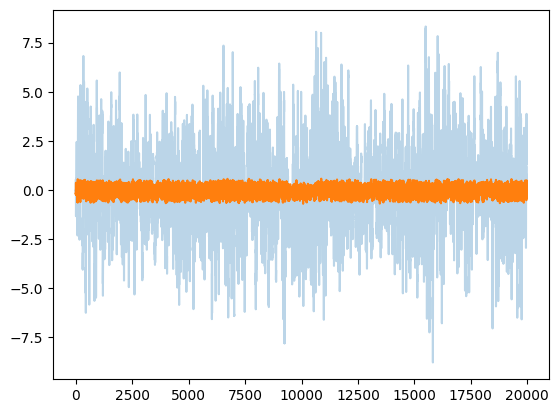

Epoch[3/5] | loss train:415.233367, val loss:96.810754 | lr:0.001000 | r2: 0.00630|
[-0.15005514 -0.12891883 -0.12748079 ...  0.0110605  -0.01089875
 -0.02677737]
[-0.00957358  0.00682015 -0.12866649 ...  1.2952496   1.8182437
  2.62303   ]


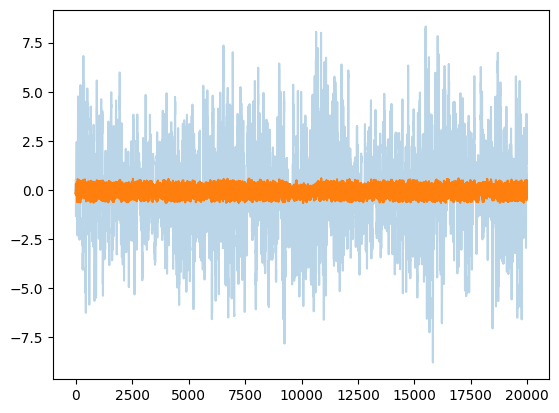

Epoch[4/5] | loss train:415.087593, val loss:96.753602 | lr:0.001000 | r2: 0.00678|
[-0.15999973 -0.13063374 -0.12940812 ... -0.05749713 -0.04313874
 -0.05859512]
[-0.00957358  0.00682015 -0.12866649 ...  1.2952496   1.8182437
  2.62303   ]


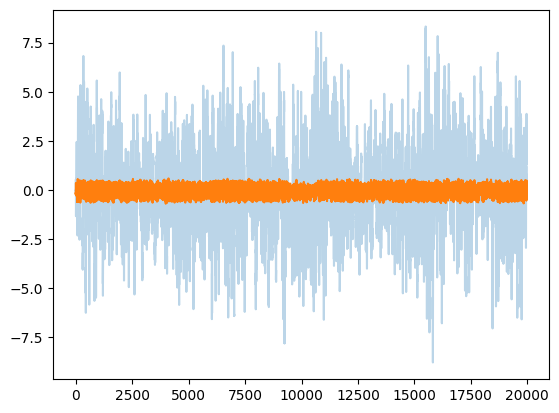

Epoch[5/5] | loss train:414.845576, val loss:96.731822 | lr:0.001000 | r2: 0.00703|
Done with prediction len 21.
Train data shape (79902, 100, 38) (79902,)
Validation data shape (19976, 100, 38) (19976,)
[-0.11476299 -0.09771211 -0.08911197 ...  0.20071249  0.15531398
  0.15691422]
[-0.12468026 -0.12675339  0.0737305  ...  2.020395    2.5532324
  2.7364151 ]


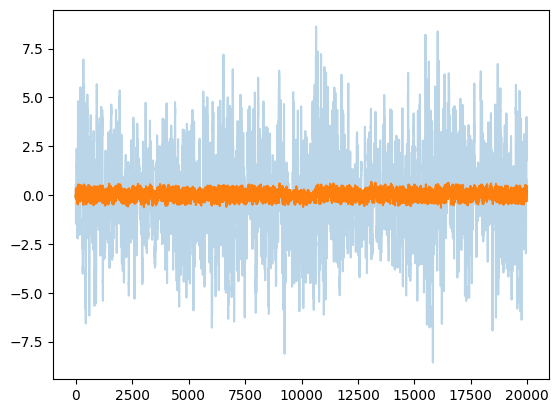

Epoch[1/5] | loss train:417.275571, val loss:96.635939 | lr:0.001000 | r2: 0.00366|
[-0.14510038 -0.12069072 -0.11063145 ...  0.10592249  0.07859847
  0.06902221]
[-0.12468026 -0.12675339  0.0737305  ...  2.020395    2.5532324
  2.7364151 ]


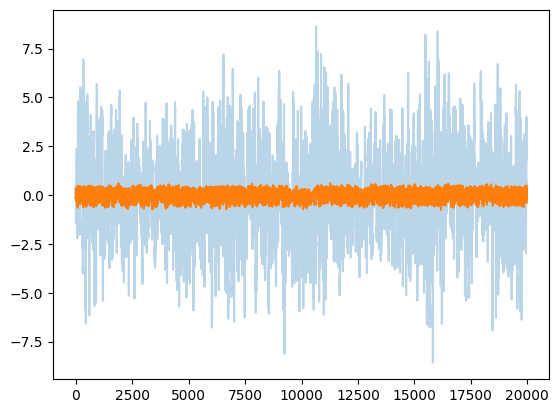

Epoch[2/5] | loss train:415.657228, val loss:96.521776 | lr:0.001000 | r2: 0.00474|
[-0.14020266 -0.11248568 -0.10323672 ...  0.07806332  0.04812355
  0.05420053]
[-0.12468026 -0.12675339  0.0737305  ...  2.020395    2.5532324
  2.7364151 ]


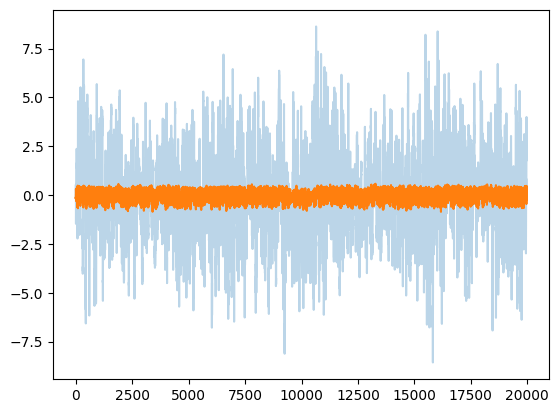

Epoch[3/5] | loss train:415.352475, val loss:96.454041 | lr:0.001000 | r2: 0.00538|
[-0.15524086 -0.1265389  -0.11825429 ...  0.03383962  0.02782657
  0.02972761]
[-0.12468026 -0.12675339  0.0737305  ...  2.020395    2.5532324
  2.7364151 ]


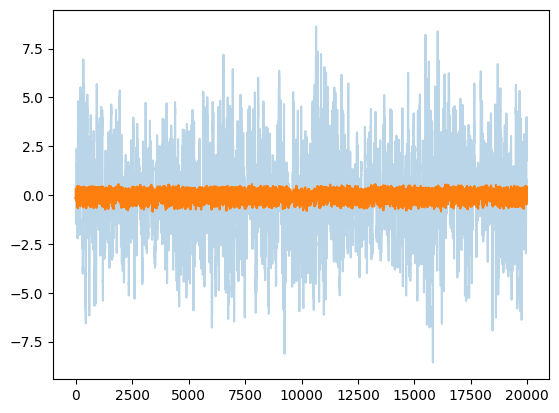

Epoch[4/5] | loss train:415.046574, val loss:96.409733 | lr:0.001000 | r2: 0.00582|
[-0.13678744 -0.10537402 -0.09740621 ...  0.07325533  0.05386044
  0.02592723]
[-0.12468026 -0.12675339  0.0737305  ...  2.020395    2.5532324
  2.7364151 ]


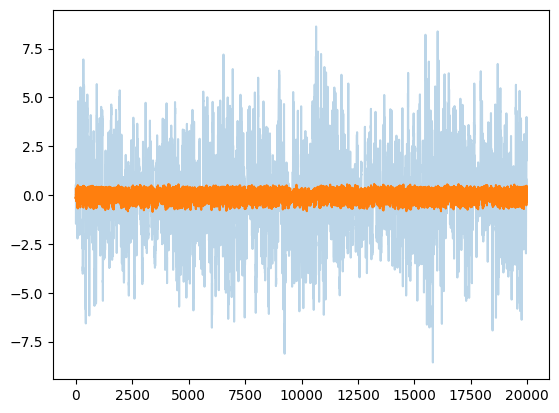

Epoch[5/5] | loss train:414.798351, val loss:96.429355 | lr:0.001000 | r2: 0.00550|
Done with prediction len 22.
Train data shape (79901, 100, 38) (79901,)
Validation data shape (19976, 100, 38) (19976,)
[-0.09779593 -0.087123   -0.08346625 ...  0.2124852   0.16545358
  0.15690115]
[-0.25218594  0.0709069   0.28191537 ...  2.734824    2.6668913
  2.4275835 ]


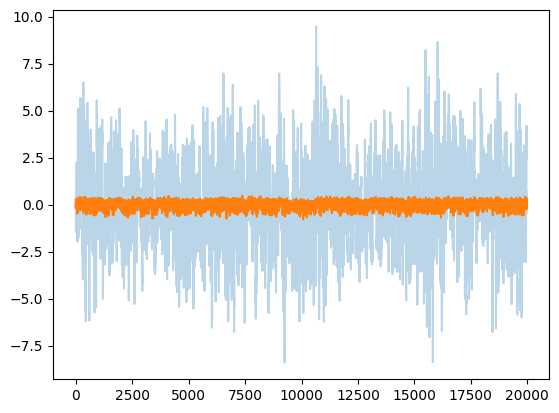

Epoch[1/5] | loss train:417.413570, val loss:96.253704 | lr:0.001000 | r2: 0.00260|
[-0.13371119 -0.11244883 -0.10388362 ...  0.14165482  0.10823439
  0.10811587]
[-0.25218594  0.0709069   0.28191537 ...  2.734824    2.6668913
  2.4275835 ]


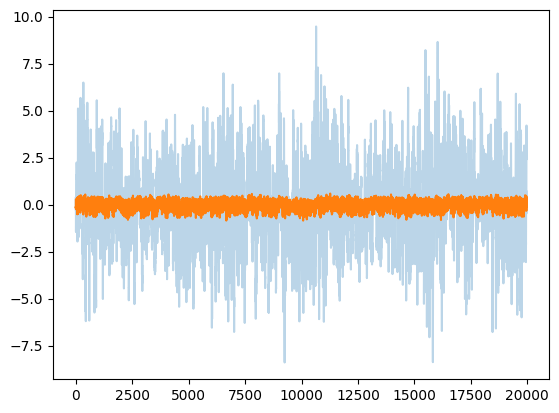

Epoch[2/5] | loss train:416.097700, val loss:96.165866 | lr:0.001000 | r2: 0.00355|
[-0.16956732 -0.14901522 -0.13892618 ...  0.13848805  0.09906986
  0.09793442]
[-0.25218594  0.0709069   0.28191537 ...  2.734824    2.6668913
  2.4275835 ]


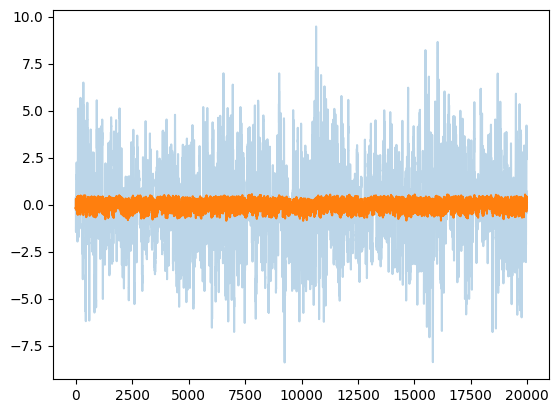

Epoch[3/5] | loss train:415.417278, val loss:96.121884 | lr:0.001000 | r2: 0.00405|
[-0.15486541 -0.12563357 -0.11361846 ...  0.04367286  0.04911875
  0.06800935]
[-0.25218594  0.0709069   0.28191537 ...  2.734824    2.6668913
  2.4275835 ]


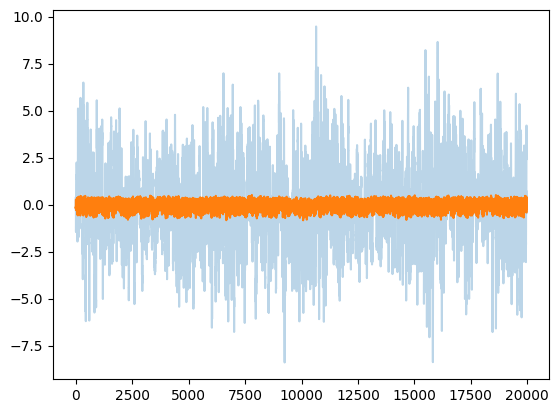

Epoch[4/5] | loss train:415.209210, val loss:96.038504 | lr:0.001000 | r2: 0.00487|
[-0.15300933 -0.12879896 -0.11580139 ...  0.09351189  0.08080357
  0.08055871]
[-0.25218594  0.0709069   0.28191537 ...  2.734824    2.6668913
  2.4275835 ]


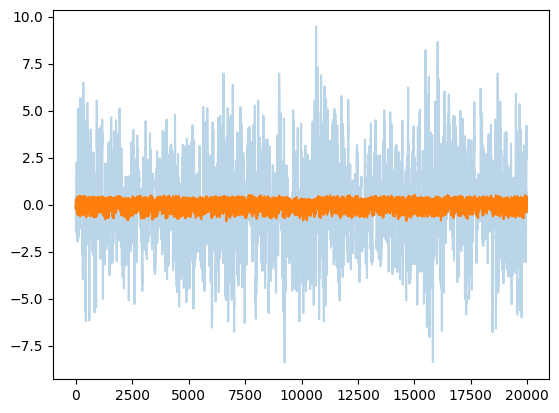

Epoch[5/5] | loss train:414.941013, val loss:95.993620 | lr:0.001000 | r2: 0.00536|
Done with prediction len 23.
Train data shape (79900, 100, 38) (79900,)
Validation data shape (19976, 100, 38) (19976,)
[-0.13619938 -0.11515334 -0.10780609 ...  0.19387749  0.13139683
  0.1089262 ]
[-0.05616604  0.2746201   0.2878969  ...  2.8431382   2.3675709
  2.241943  ]


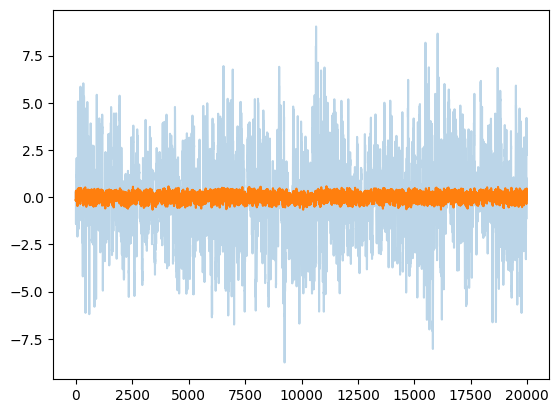

Epoch[1/5] | loss train:417.032737, val loss:95.675344 | lr:0.001000 | r2: 0.00374|
[-0.1004305  -0.07413857 -0.06455472 ...  0.12666567  0.05865827
  0.0681752 ]
[-0.05616604  0.2746201   0.2878969  ...  2.8431382   2.3675709
  2.241943  ]


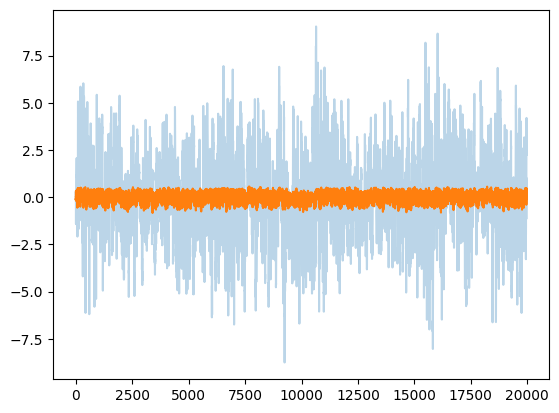

Epoch[2/5] | loss train:415.394424, val loss:95.525586 | lr:0.001000 | r2: 0.00538|
[-0.1482524  -0.11666446 -0.1071273  ...  0.06122321  0.03752835
  0.00512914]
[-0.05616604  0.2746201   0.2878969  ...  2.8431382   2.3675709
  2.241943  ]


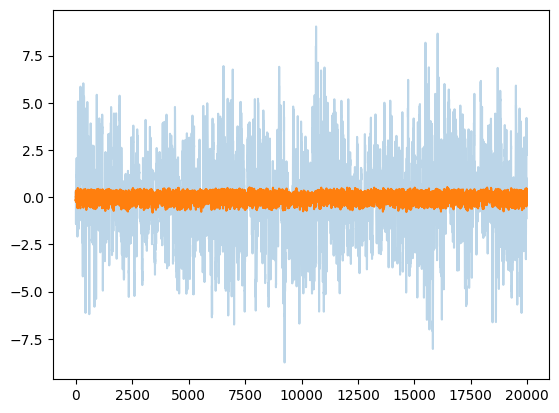

Epoch[3/5] | loss train:415.051477, val loss:95.495967 | lr:0.001000 | r2: 0.00563|
[-0.13168329 -0.09328125 -0.0817925  ...  0.03957428  0.00073143
  0.01635075]
[-0.05616604  0.2746201   0.2878969  ...  2.8431382   2.3675709
  2.241943  ]


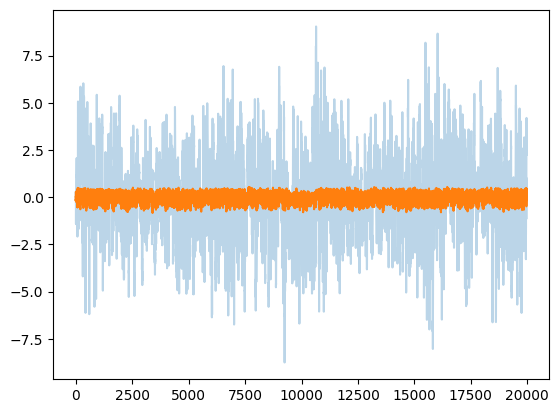

Epoch[4/5] | loss train:414.563309, val loss:95.432534 | lr:0.001000 | r2: 0.00633|
[-0.1488549  -0.11262387 -0.10454886 ... -0.00334584 -0.00096829
 -0.03114737]
[-0.05616604  0.2746201   0.2878969  ...  2.8431382   2.3675709
  2.241943  ]


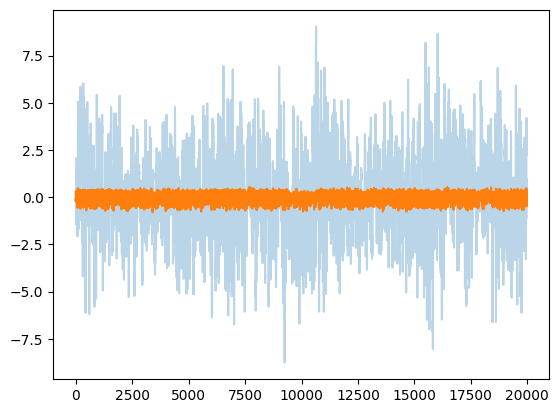

Epoch[5/5] | loss train:414.533588, val loss:95.434692 | lr:0.001000 | r2: 0.00622|
Done with prediction len 24.
Train data shape (79900, 100, 38) (79900,)
Validation data shape (19975, 100, 38) (19975,)
[-0.11155031 -0.106461   -0.11805265 ...  0.18844509  0.1517478
  0.17251274]
[0.28074405 0.16737257 0.06429821 ... 2.5474958  2.188093   2.8429005 ]


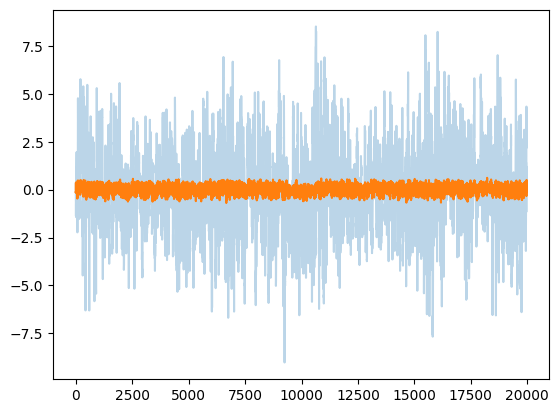

Epoch[1/5] | loss train:416.039497, val loss:95.238938 | lr:0.001000 | r2: 0.00392|
[-0.13147575 -0.12679625 -0.14533372 ...  0.11330993  0.08088376
  0.10630199]
[0.28074405 0.16737257 0.06429821 ... 2.5474958  2.188093   2.8429005 ]


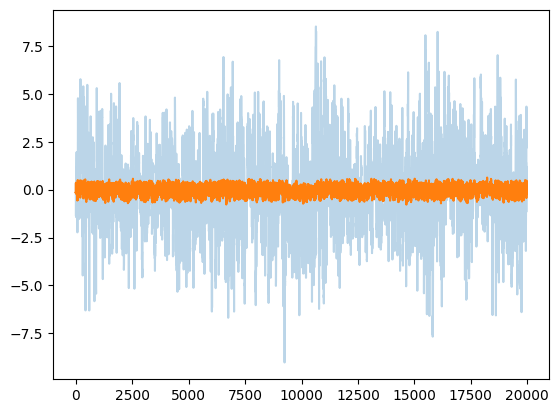

Epoch[2/5] | loss train:414.806915, val loss:95.155066 | lr:0.001000 | r2: 0.00474|
[-0.11398464 -0.10689489 -0.12989913 ...  0.06930973  0.05700177
  0.07535445]
[0.28074405 0.16737257 0.06429821 ... 2.5474958  2.188093   2.8429005 ]


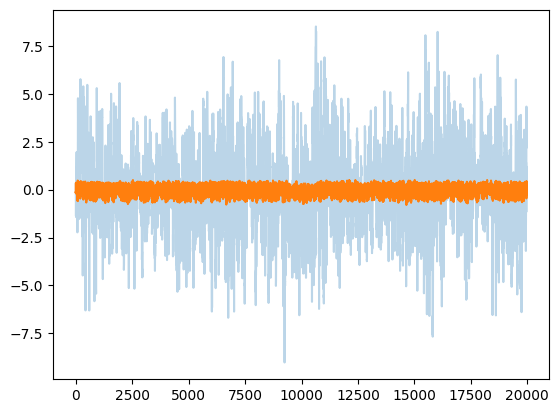

Epoch[3/5] | loss train:414.398690, val loss:95.102210 | lr:0.001000 | r2: 0.00513|
[-0.12161206 -0.1155779  -0.1362585  ...  0.04519163  0.02074097
  0.05050038]
[0.28074405 0.16737257 0.06429821 ... 2.5474958  2.188093   2.8429005 ]


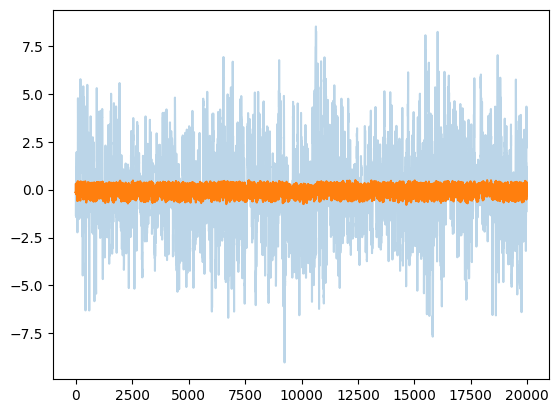

Epoch[4/5] | loss train:414.019687, val loss:95.042341 | lr:0.001000 | r2: 0.00576|
[-0.07871497 -0.07100201 -0.09843617 ...  0.06620859  0.04902284
  0.05023544]
[0.28074405 0.16737257 0.06429821 ... 2.5474958  2.188093   2.8429005 ]


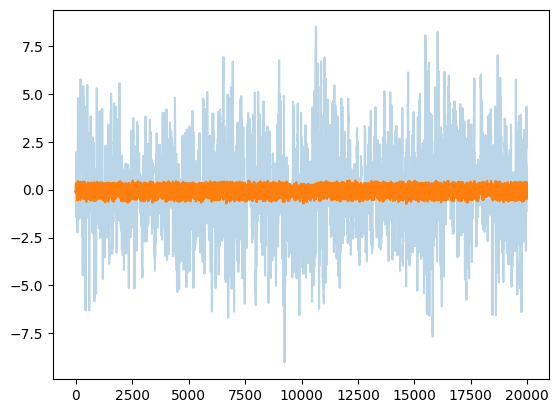

Epoch[5/5] | loss train:413.902460, val loss:95.053687 | lr:0.001000 | r2: 0.00557|
Done with prediction len 25.
Train data shape (79899, 100, 38) (79899,)
Validation data shape (19975, 100, 38) (19975,)
[-0.08325581 -0.07809929 -0.09991223 ...  0.21562645  0.1647833
  0.13897806]
[ 0.16291478  0.04346404 -0.04229121 ...  2.3688967   2.7788055
  2.9556808 ]


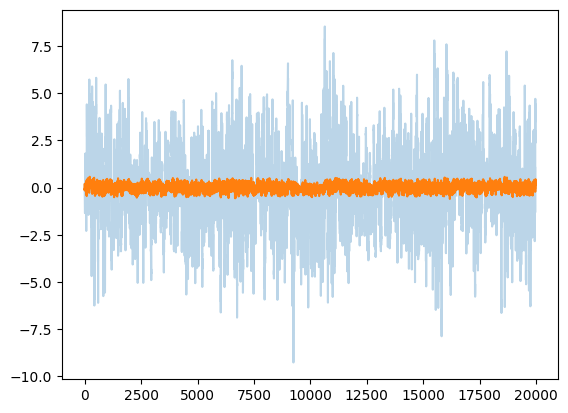

Epoch[1/5] | loss train:415.519842, val loss:94.821710 | lr:0.001000 | r2: 0.00382|
[-0.11860452 -0.11497573 -0.15440711 ...  0.15427727  0.13419071
  0.12990966]
[ 0.16291478  0.04346404 -0.04229121 ...  2.3688967   2.7788055
  2.9556808 ]


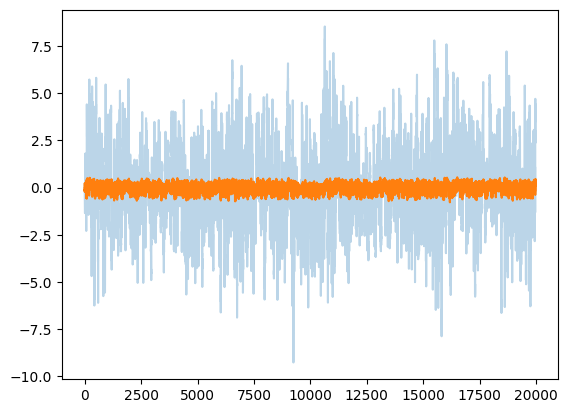

Epoch[2/5] | loss train:413.967257, val loss:94.727654 | lr:0.001000 | r2: 0.00483|
[-0.11922302 -0.11545382 -0.1554369  ...  0.08950681  0.06653793
  0.06832294]
[ 0.16291478  0.04346404 -0.04229121 ...  2.3688967   2.7788055
  2.9556808 ]


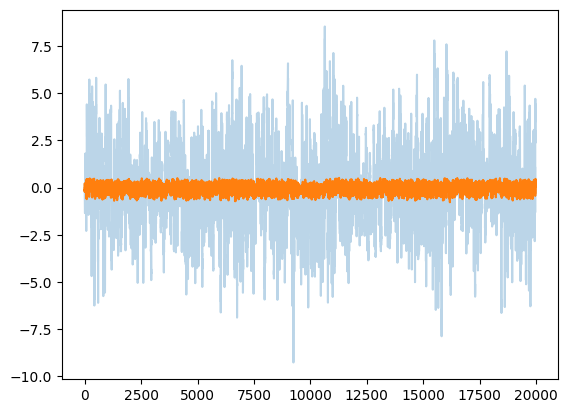

Epoch[3/5] | loss train:413.562380, val loss:94.692944 | lr:0.001000 | r2: 0.00504|
[-0.10907651 -0.10360368 -0.14891104 ...  0.06610118  0.04992393
  0.06172473]
[ 0.16291478  0.04346404 -0.04229121 ...  2.3688967   2.7788055
  2.9556808 ]


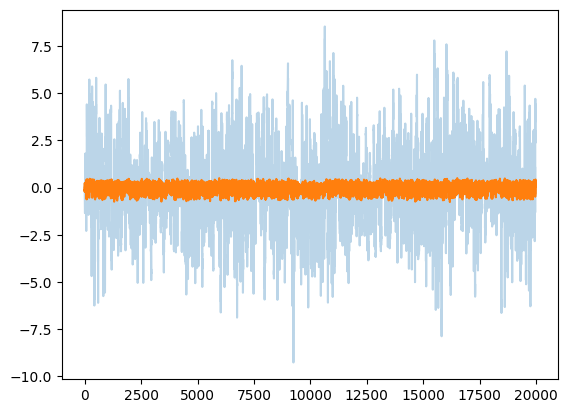

Epoch[4/5] | loss train:413.464866, val loss:94.654621 | lr:0.001000 | r2: 0.00541|
[-0.08613853 -0.08146508 -0.12934147 ...  0.03928217  0.03292251
  0.05567789]
[ 0.16291478  0.04346404 -0.04229121 ...  2.3688967   2.7788055
  2.9556808 ]


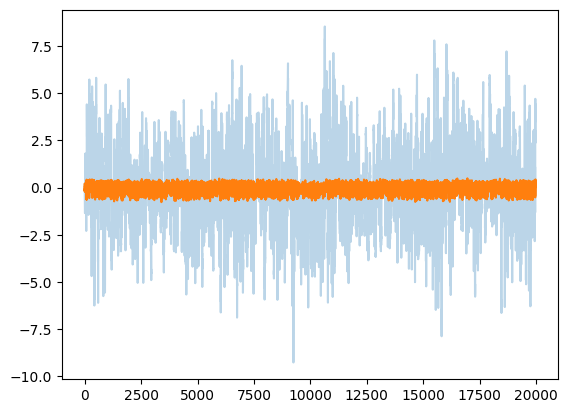

Epoch[5/5] | loss train:413.311730, val loss:94.661115 | lr:0.001000 | r2: 0.00532|
Done with prediction len 26.
Train data shape (79898, 100, 38) (79898,)
Validation data shape (19975, 100, 38) (19975,)
[-0.06211893 -0.06130606 -0.07005421 ...  0.1725482   0.13876918
  0.12479088]
[ 0.04157008 -0.06061569 -0.1265259  ...  2.9453073   2.891621
  2.7021189 ]


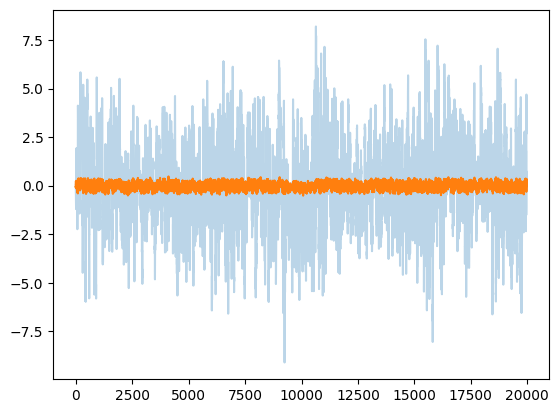

Epoch[1/5] | loss train:415.127253, val loss:94.397909 | lr:0.001000 | r2: 0.00456|
[-0.0628079  -0.05894162 -0.07446799 ...  0.17337811  0.10974919
  0.09809408]
[ 0.04157008 -0.06061569 -0.1265259  ...  2.9453073   2.891621
  2.7021189 ]


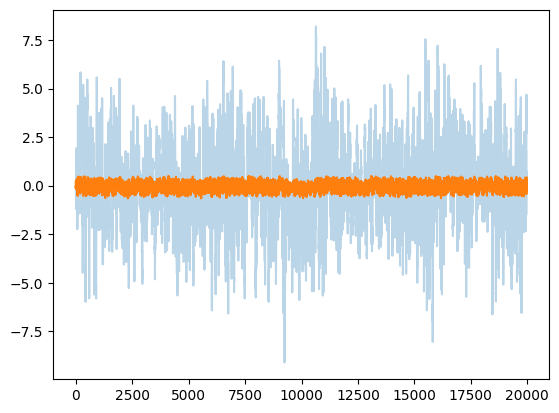

Epoch[2/5] | loss train:413.114775, val loss:94.313101 | lr:0.001000 | r2: 0.00540|
[-0.08947076 -0.08746368 -0.10893821 ...  0.06293202  0.0230737
  0.01100879]
[ 0.04157008 -0.06061569 -0.1265259  ...  2.9453073   2.891621
  2.7021189 ]


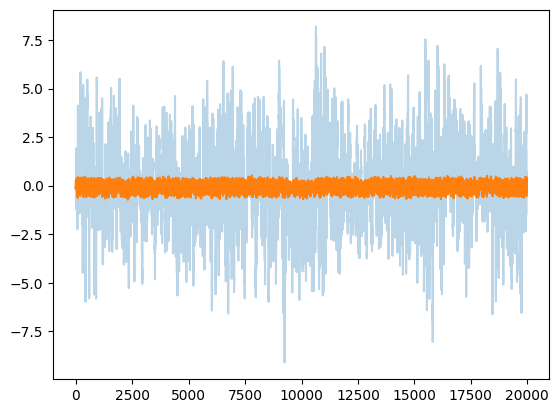

Epoch[3/5] | loss train:412.695668, val loss:94.284881 | lr:0.001000 | r2: 0.00557|
[-0.08435    -0.08060887 -0.10142897 ...  0.05528448  0.01612095
  0.00457922]
[ 0.04157008 -0.06061569 -0.1265259  ...  2.9453073   2.891621
  2.7021189 ]


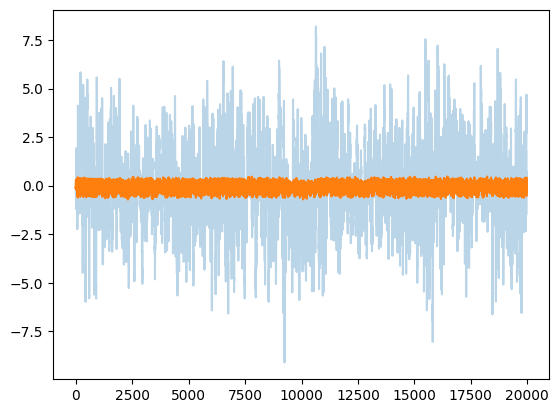

Epoch[4/5] | loss train:412.544386, val loss:94.261090 | lr:0.001000 | r2: 0.00577|
[-0.0349749  -0.03009334 -0.05582576 ...  0.02242454  0.00171186
 -0.01061061]
[ 0.04157008 -0.06061569 -0.1265259  ...  2.9453073   2.891621
  2.7021189 ]


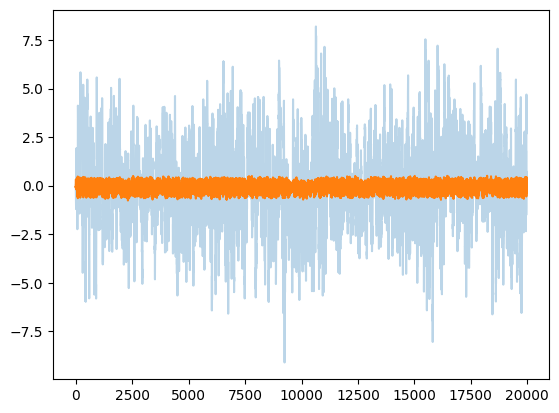

Epoch[5/5] | loss train:412.357730, val loss:94.266347 | lr:0.001000 | r2: 0.00571|
Done with prediction len 27.
Train data shape (79897, 100, 38) (79897,)
Validation data shape (19975, 100, 38) (19975,)
[-0.06859563 -0.06489712 -0.06935155 ...  0.21279576  0.17441458
  0.15086284]
[-0.06050003 -0.14293262 -0.27384064 ...  3.0537562   2.6449904
  2.7886333 ]


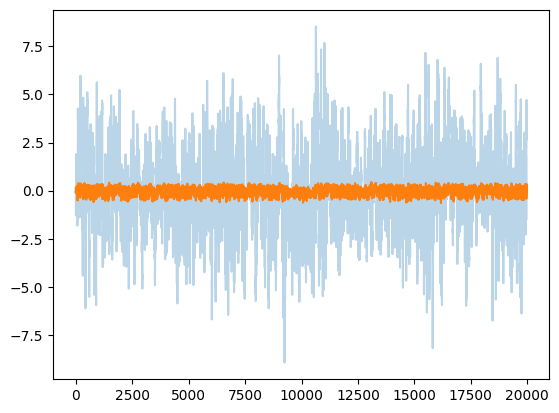

Epoch[1/5] | loss train:414.284148, val loss:94.174893 | lr:0.001000 | r2: 0.00382|
[-0.06589089 -0.05815194 -0.05949885 ...  0.21605343  0.15086335
  0.11442607]
[-0.06050003 -0.14293262 -0.27384064 ...  3.0537562   2.6449904
  2.7886333 ]


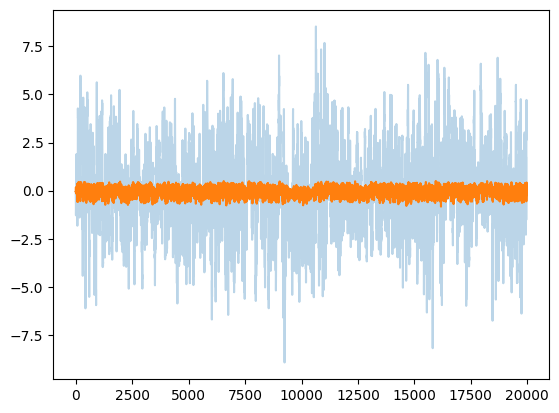

Epoch[2/5] | loss train:412.684662, val loss:94.057773 | lr:0.001000 | r2: 0.00496|
[-0.08453503 -0.07955382 -0.09860527 ...  0.09781404  0.04810734
  0.03028556]
[-0.06050003 -0.14293262 -0.27384064 ...  3.0537562   2.6449904
  2.7886333 ]


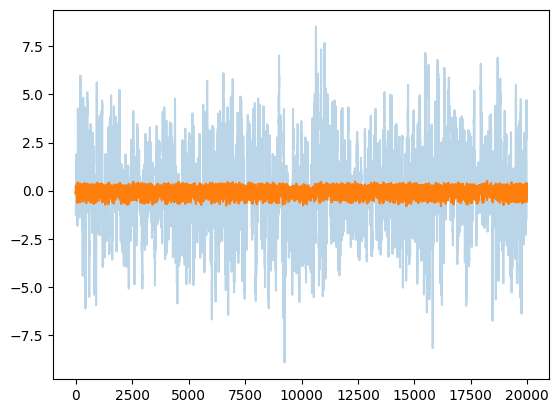

Epoch[3/5] | loss train:412.150229, val loss:93.992871 | lr:0.001000 | r2: 0.00547|
[-0.05277004 -0.0427992  -0.0601993  ...  0.09351937  0.04917997
  0.02046781]
[-0.06050003 -0.14293262 -0.27384064 ...  3.0537562   2.6449904
  2.7886333 ]


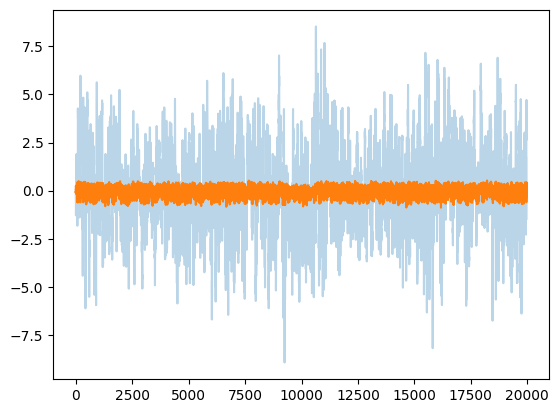

Epoch[4/5] | loss train:411.716754, val loss:93.963004 | lr:0.001000 | r2: 0.00593|
[-0.06937208 -0.06338396 -0.08552583 ...  0.08183008  0.05532387
  0.02576599]
[-0.06050003 -0.14293262 -0.27384064 ...  3.0537562   2.6449904
  2.7886333 ]


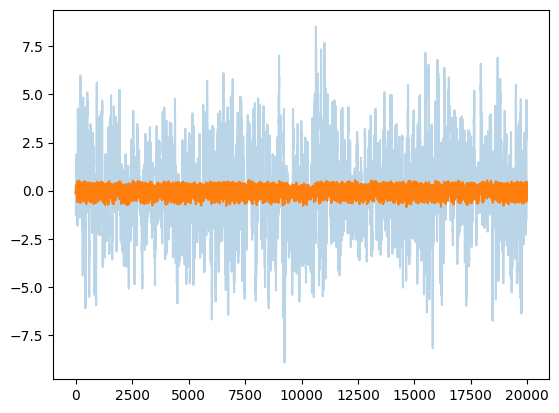

Epoch[5/5] | loss train:411.451781, val loss:93.912096 | lr:0.001000 | r2: 0.00648|
Done with prediction len 28.
Train data shape (79896, 100, 38) (79896,)
Validation data shape (19975, 100, 38) (19975,)
[-0.12790424 -0.12098102 -0.1356893  ...  0.20254493  0.15673357
  0.15847677]
[-0.14133981 -0.28730702 -0.26968908 ...  2.8095264   2.731778
  2.8667774 ]


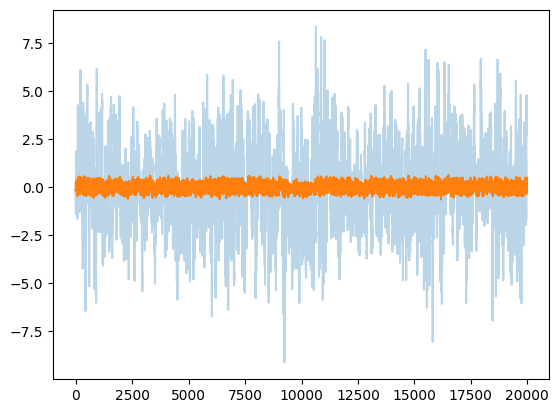

Epoch[1/5] | loss train:413.164567, val loss:93.875385 | lr:0.001000 | r2: 0.00458|
[-0.14791092 -0.14387015 -0.16198161 ...  0.11154208  0.08486918
  0.06380004]
[-0.14133981 -0.28730702 -0.26968908 ...  2.8095264   2.731778
  2.8667774 ]


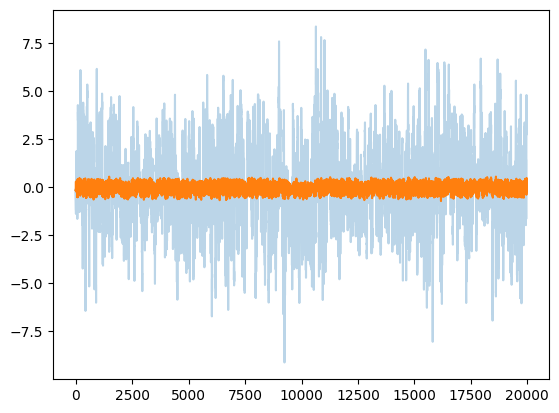

Epoch[2/5] | loss train:411.839676, val loss:93.798597 | lr:0.001000 | r2: 0.00528|
[-0.11301357 -0.1022969  -0.12089548 ...  0.02385392  0.00882936
  0.05186959]
[-0.14133981 -0.28730702 -0.26968908 ...  2.8095264   2.731778
  2.8667774 ]


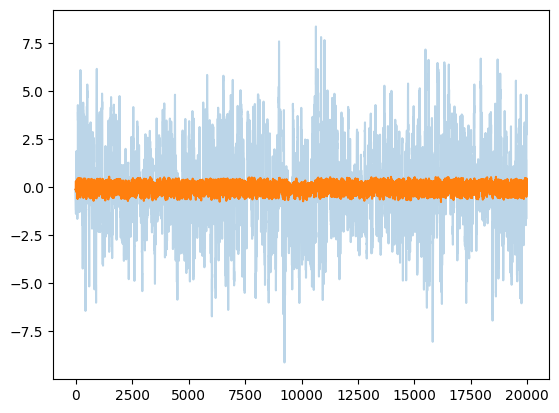

Epoch[3/5] | loss train:411.391629, val loss:93.722489 | lr:0.001000 | r2: 0.00607|
[-0.11987165 -0.11094141 -0.13912454 ... -0.0036048  -0.01557318
  0.00233483]
[-0.14133981 -0.28730702 -0.26968908 ...  2.8095264   2.731778
  2.8667774 ]


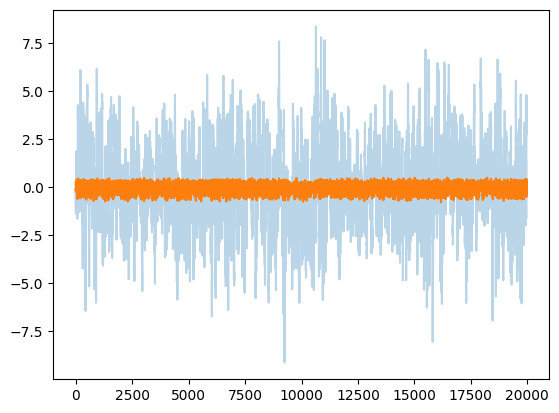

Epoch[4/5] | loss train:411.340946, val loss:93.778117 | lr:0.001000 | r2: 0.00531|
[-0.0445405  -0.03647332 -0.05817136 ... -0.01423297 -0.03685337
 -0.01919146]
[-0.14133981 -0.28730702 -0.26968908 ...  2.8095264   2.731778
  2.8667774 ]


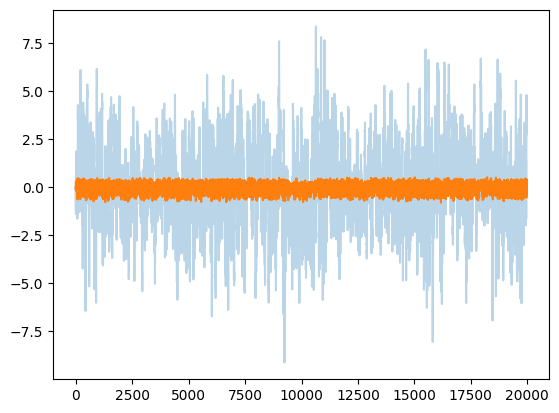

Epoch[5/5] | loss train:411.030427, val loss:93.742008 | lr:0.001000 | r2: 0.00564|
Done with prediction len 29.
Train data shape (79896, 100, 38) (79896,)
Validation data shape (19974, 100, 38) (19974,)
[-0.0181115  -0.04440308 -0.11768664 ...  0.21181427  0.16961603
  0.1474719 ]
[-0.28306788 -0.2649708  -0.08010545 ...  2.8926294   2.8103242
  2.3983107 ]


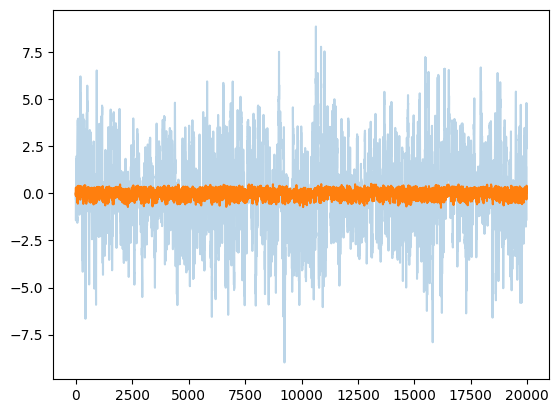

Epoch[1/5] | loss train:413.073160, val loss:93.743554 | lr:0.001000 | r2: 0.00418|
[-0.06026305 -0.08589993 -0.15396544 ...  0.16789806  0.1027451
  0.07275896]
[-0.28306788 -0.2649708  -0.08010545 ...  2.8926294   2.8103242
  2.3983107 ]


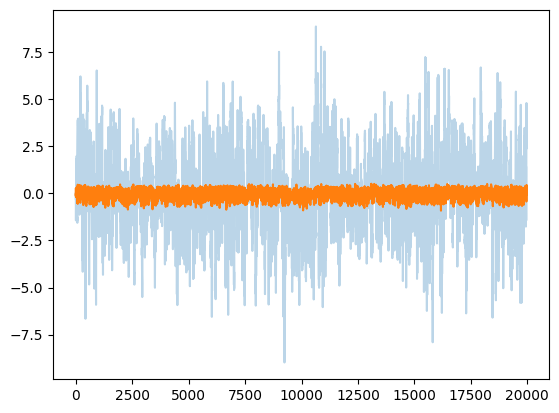

Epoch[2/5] | loss train:411.463705, val loss:93.649855 | lr:0.001000 | r2: 0.00511|
[-0.07502368 -0.09952132 -0.17166403 ...  0.05487866  0.00846331
 -0.00486802]
[-0.28306788 -0.2649708  -0.08010545 ...  2.8926294   2.8103242
  2.3983107 ]


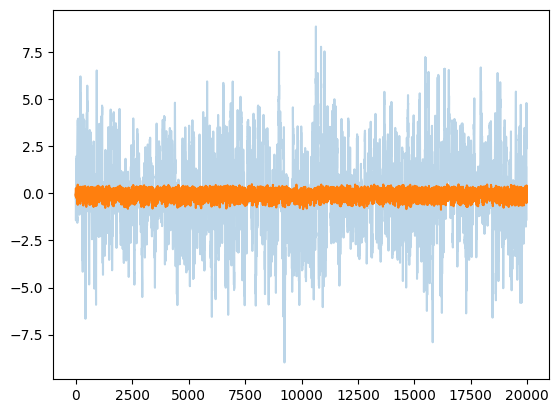

Epoch[3/5] | loss train:411.310187, val loss:93.678398 | lr:0.001000 | r2: 0.00465|
[-0.04807524 -0.07781565 -0.15231785 ...  0.09094571  0.03914744
  0.01781094]
[-0.28306788 -0.2649708  -0.08010545 ...  2.8926294   2.8103242
  2.3983107 ]


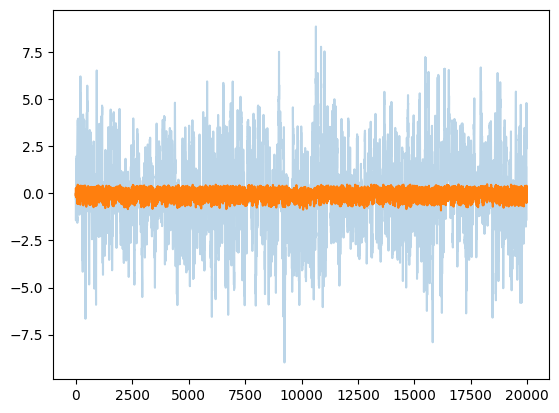

Epoch[4/5] | loss train:411.076081, val loss:93.613442 | lr:0.001000 | r2: 0.00545|
[-0.01600429 -0.05075102 -0.1298873  ...  0.04087183  0.00413409
 -0.00506549]
[-0.28306788 -0.2649708  -0.08010545 ...  2.8926294   2.8103242
  2.3983107 ]


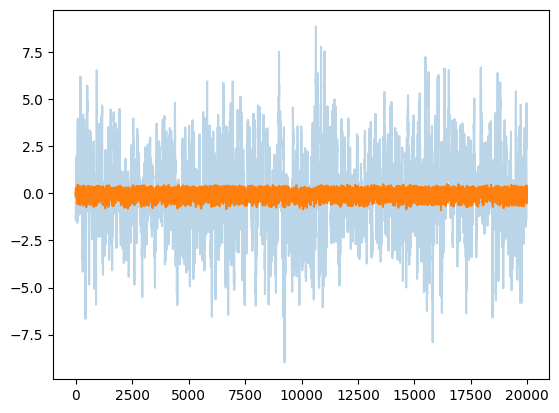

Epoch[5/5] | loss train:410.952860, val loss:93.657362 | lr:0.001000 | r2: 0.00486|
Done with prediction len 30.
Train data shape (79895, 100, 38) (79895,)
Validation data shape (19974, 100, 38) (19974,)
[-0.11123951 -0.12061377 -0.14213032 ...  0.1593936   0.10082799
  0.09066754]
[-0.27827227 -0.25545248  0.09943195 ...  2.9678092   2.3515437
  1.9839469 ]


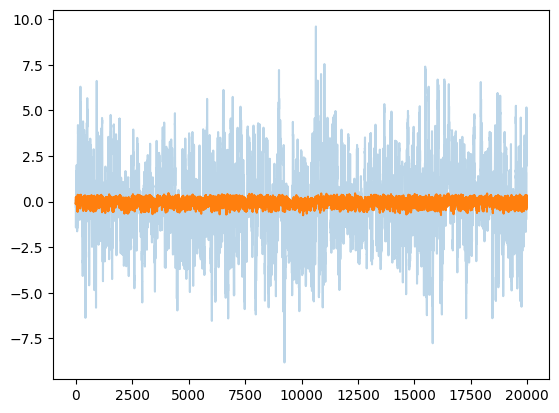

Epoch[1/5] | loss train:412.595534, val loss:93.566161 | lr:0.001000 | r2: 0.00397|
[-0.10573846 -0.11678387 -0.13665359 ...  0.14496224  0.08279938
  0.04960517]
[-0.27827227 -0.25545248  0.09943195 ...  2.9678092   2.3515437
  1.9839469 ]


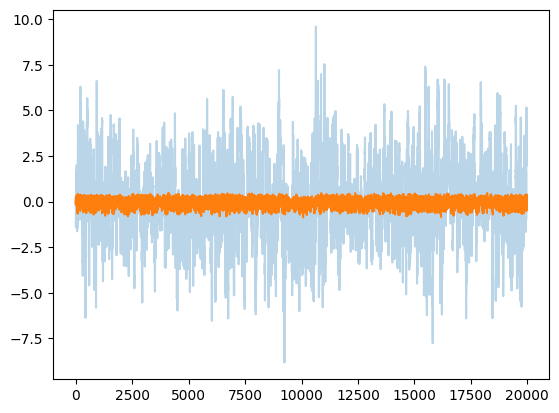

Epoch[2/5] | loss train:411.512250, val loss:93.508873 | lr:0.001000 | r2: 0.00451|
[-0.0861565  -0.10289574 -0.13325231 ...  0.06345166  0.01280156
  0.00164634]
[-0.27827227 -0.25545248  0.09943195 ...  2.9678092   2.3515437
  1.9839469 ]


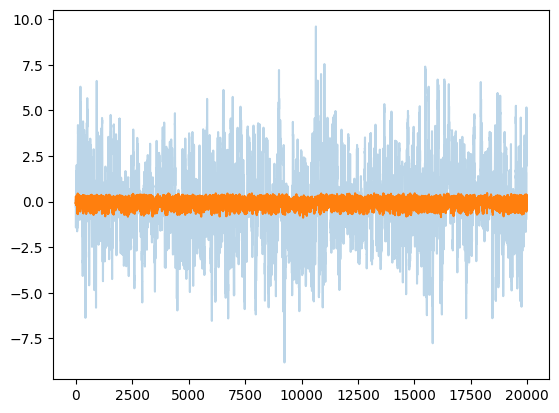

Epoch[3/5] | loss train:411.357544, val loss:93.511014 | lr:0.001000 | r2: 0.00446|
[-0.05778761 -0.07536873 -0.10915383 ...  0.07049261  0.01725187
 -0.00808341]
[-0.27827227 -0.25545248  0.09943195 ...  2.9678092   2.3515437
  1.9839469 ]


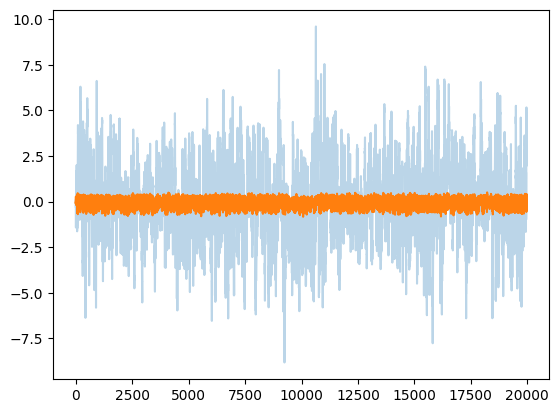

Epoch[4/5] | loss train:411.063979, val loss:93.473304 | lr:0.001000 | r2: 0.00482|
[-0.00716872 -0.02256815 -0.05155737 ...  0.03207116 -0.0041807
 -0.00948994]
[-0.27827227 -0.25545248  0.09943195 ...  2.9678092   2.3515437
  1.9839469 ]


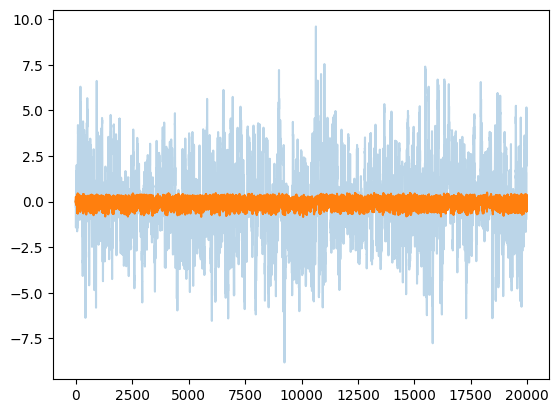

Epoch[5/5] | loss train:410.806571, val loss:93.476957 | lr:0.001000 | r2: 0.00485|
Done with prediction len 31.


In [17]:
# lag=1
save_path = os.path.join(f'{current_working_directory}/{model_add_path}',
                            str(int(time.time()))+'_results.csv')
# Create the directory if it doesn't exist

forecast_windows = [i for i in range(1,32)]


for lag in forecast_windows:
    orderbook = augment_trade_data(agg_trade, forecast_window=lag)

    features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9' ]

    split_index, data_x_train, data_y_train, data_x_val, data_y_val = prepare_data(np.array(orderbook[features][0:100000]),
                                                                                                                            np.array(agg_trade.datetime[2_005_000:2_006_000]),
                                                                                                                            np.array(orderbook[features][60_000:60_600]),
                                                                                                                            np.array(agg_trade.datetime[60_000:60_600]),
                                                                                                                            config, lag=lag, plot=False)


    dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
    dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

    print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
    print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
    # print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)


    model_MO = LSTM_MO(input_size=len(features), hidden_layer_size=64,
                    num_layers=2, output_size=config["model_MO"]["output_size"], dropout=0.2)

    model_MO = model_MO.to(device)

    # create DataLoader
    train_dataloader = DataLoader(dataset_train, batch_size=config["training_MO"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(dataset_val, batch_size=config["training_MO"]["batch_size"], shuffle=False)

    model_MO.train_model(train_dataloader=train_dataloader, val_dataloader=val_dataloader, learning_rate=0.001,
                scheduler_step_size=config["training_MO"]["scheduler_step_size"], n_epochs=5,
                device='cuda', save_path=save_path, forecast_window=lag)

    # date_now = datetime.now()
    # timestamp = date_now.strftime("%d-%b-%Y_%H:%M:%S.%f")
    del data_x_train 
    del data_y_train
    del data_x_val
    del data_y_val

    # torch.save(model_MO, f'{current_working_directory}/othermodels/{model_add_path}/No.1/LSTM_MO_LAG_{lag}.pt')
    model_save_path = f'{current_working_directory}/{model_add_path}/No.2'
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    torch.save(model_MO, f'{model_save_path}/LSTM_MO_LAG_{lag}.pt')
    print(f'Done with prediction len {lag}.')

In [ ]:
plt.hist(np.random.normal(size = len(data_y_train)*3), bins=150, alpha=0.5)
plt.hist(data_y_train, bins=150, alpha=0.7)

In [ ]:
np.std(data_y_train)

In [ ]:
lags = [i for i in range(31)]

orderbook = augment_trade_data(agg_trade, forecast_window=lag)
means = []
stds = []

for lag in lags:
    split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen, data_x_test, data_y_test = prepare_data(np.array(orderbook[['price','bid1']][1_200_000:2_200_000]),
                                                                                                                        np.array(agg_trade.datetime[2_000_000:2_100_000]),
                                                                                                                        np.array(orderbook[['price','bid1']][60_000:65_000]),
                                                                                                                        np.array(agg_trade.datetime[60_000:65_000]),
                                                                                                                        config, lag=lag, plot=False)
    mean = np.mean(data_y_train)
    std =  np.std(data_y_train)
    means.append(mean) 
    stds.append(std)             
    print(f'mean for lag {lag} {mean}')
    print(f'std for lag {lag} {std}')

In [ ]:
plt.plot(means)

In [ ]:
plt.plot(stds)

In [ ]:
stds